In [48]:
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from scipy.optimize import curve_fit
from scipy.ndimage import interpolation
from statsmodels.stats.anova import AnovaRM
import time
import sys
import math
import pylab as py
from scipy.signal import savgol_filter
from scipy.optimize import least_squares
import seaborn as sns

import statannot
import scipy.stats as sci 
# from scipy.stats import norm

In [49]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (5,5)
sns.set_theme(style="darkgrid")


In [50]:
# from google.colab import drive
# drive.mount('/content/drive')

In [51]:
def ResizeArray(data, newSize):
    x = data
    i = newSize
    z = i / len(x)
    x_int = interpolation.zoom(x,z)

    return x_int

def AngularCorrection(data):
    outputarr = []
    for i in data:
        if i>180:
            outputarr.append(i - 270)
        else:
            outputarr.append(i + 90)

    return outputarr

def AverageCurve(data,col):
    # plt.figure()
    ydata = np.mean(data,axis=0)
    xvls = np.linspace(0,len(ydata),len(ydata)) 
    yerr = np.std(data, axis=0) / np.sqrt(np.shape(data)[0])
    plt.plot(xvls,ydata,color=col)
    plt.fill_between(xvls, ydata-yerr, ydata+yerr, alpha=0.5,color=[0.1,0.1,0.1])

# marker='s', mfc='red', mec='red', ms=5, mew=2,

def PlotErrorBars(dataX = np.tile(np.nan,10), dataY = np.tile(np.nan,10), dataZ = np.tile(np.nan,10), colorz = 'r'):
    # Clean up outliers 5x outside the mean  
    xData =  [(i * np.nan) if i > (np.nanmean(dataX) * 5.0) else i for i in dataX]
    yData =  [(i * np.nan) if i > (np.nanmean(dataY) * 5.0) else i for i in dataY]
    zData =  [(i * np.nan) if i > (np.nanmean(dataZ) * 5.0) else i for i in dataZ]

    # Compute standard errors
    x_SE  = np.std(xData, axis=0) / np.sqrt(np.shape(xData)[0])
    y_SE  = np.std(yData, axis=0) / np.sqrt(np.shape(yData)[0])
    z_SE  = np.std(zData, axis=0) / np.sqrt(np.shape(zData)[0])
    all_SE = [x_SE, y_SE, z_SE]

    # Plot data 
    plt.errorbar([0,1,2], [np.nanmean(xData),np.nanmean(yData),np.nanmean(zData)], all_SE, color = colorz, marker='s')


def PlotErrorBars2(dataX = np.tile(np.nan,10), colorz = 'r'):
    # Clean up outliers 5x outside the mean  
    xData =  [(i * np.nan) if i > (np.nanmean(dataX) * 5.0) else i for i in dataX]

    # Compute standard errors
    x_SE  = np.std(xData, axis=0) / np.sqrt(np.shape(xData)[0])

    # Plot data 
    plt.errorbar([0], np.nanmean(xData), x_SE, color = colorz, marker='s')

# Data Extractor

In [52]:
def DataExtractor(trackedObject, phase):
  
    df_interp = None
    newArrLength = 1000

    trialsMask = (df['info'] == trackedObject) & (df['Phase'] == phase) 
    trialsOfInterest = pd.unique(df[trialsMask].trialNumber)

    for i in trialsOfInterest:
    # print(df['inShotRegion'].iloc[i:])
    # if df['inShotRegion'].iloc[i] == True:

        # Set desired masks
        objMask = (df['info'] == trackedObject) & (df['Phase'] == phase) & (df['trialNumber'] == i) # & (df['inShotRegion'] == True)
        timeMask = df.loc[(df['info'] == trackedObject) & (df['Phase'] == phase) & (df['trialNumber'] == i),['tyme']]
        cueBallMask = (df['info'] == 'Cueball') & (df['Phase'] == phase) & (df['trialNumber'] == i) # This variable mask will help us determine impact time 
        targetBallMask = (df['info'] == 'TargetBall') & (df['Phase'] == phase) & (df['trialNumber'] == i)

        # Resize all variables 
        ##########################################################################

        # Extract data from desired objects (Special cases here)
        zPos_cueball = ResizeArray(df[cueBallMask].zPos, newArrLength)
        zPos_targball = ResizeArray(df[targetBallMask].zPos, newArrLength)

        xRot_interp = ResizeArray(df[objMask].xRot, newArrLength)
        yRot_interp = ResizeArray(df[objMask].yRot, newArrLength)
        zRot_interp = ResizeArray(df[objMask].zRot, newArrLength)

        xPos_interp = ResizeArray(df[objMask].xPos, newArrLength)
        yPos_interp = ResizeArray(df[objMask].yPos, newArrLength)
        zPos_interp = ResizeArray(df[objMask].zPos, newArrLength)

        time_interp = ResizeArray(timeMask.tyme, newArrLength)

        ##########################################################################

        # Compute angular velocities
        xRv = savgol_filter(xRot_interp, 75, 4)
        xRot_vel = np.gradient(xRv)
        yRv = savgol_filter(yRot_interp, 75, 4)
        yRot_vel = np.gradient(yRv)
        zRv = savgol_filter(zRot_interp, 75, 4)
        zRot_vel = np.gradient(zRv)

        # Compute linear velocities 
        x_v = savgol_filter(xPos_interp, 75, 4)
        x_vel = np.gradient(x_v)
        y_v = savgol_filter(yPos_interp, 75, 4)
        y_vel = np.gradient(y_v)
        z_v = savgol_filter(zPos_interp, 75, 4)
        z_vel = np.gradient(z_v)

        # Save data to new dataframe 
        dataList = zip(xRot_interp, yRot_interp, zRot_interp, time_interp)
        tmpDF_int = pd.DataFrame(dataList, columns=['xRot','yRot','zRot', 'time'])

        tmpDF_int.insert(0, "zPos_targBall", zPos_targball, True)
        tmpDF_int.insert(0, "zPos_cueBall", zPos_cueball, True)

        tmpDF_int.insert(0, "zAngVel", zRot_vel, True)
        tmpDF_int.insert(0, "yAngVel", yRot_vel, True)
        tmpDF_int.insert(0, "xAngVel", xRot_vel, True)

        tmpDF_int.insert(0, "zVel", z_vel, True)
        tmpDF_int.insert(0, "yVel", y_vel, True)
        tmpDF_int.insert(0, "xVel", x_vel, True)

        tmpDF_int.insert(0, "zPos", zPos_interp, True)
        tmpDF_int.insert(0, "yPos", yPos_interp, True)
        tmpDF_int.insert(0, "xPos", xPos_interp, True)

        tmpDF_int.insert(0, "Phase", phase, True)
        tmpDF_int.insert(0, "trialNum", i, True)


        if df_interp is None:
            df_interp = tmpDF_int
        else:
            df_interp = pd.concat((df_interp, tmpDF_int))

    return df_interp, trialsOfInterest

# Metric extractor

In [53]:

def AverageAngPos(df_int, trials):
    xRots, yRots, zRots = [], [], []
    xPosAv, yPosAv, zPosAv = [],[],[]
    for i in trials:
        mask_1 = (df_int['trialNum'] == i) 
        xRots.append(df_int.xRot[mask_1])
        yRots.append(df_int.yRot[mask_1])
        zRots.append(df_int.zRot[mask_1])
        xPosAv.append(df_int.xPos[mask_1])
        yPosAv.append(df_int.yPos[mask_1])
        zPosAv.append(df_int.zPos[mask_1])
        
    return xRots, yRots, zRots, xPosAv, yPosAv, zPosAv

def AvAngVel(df_int, trials):
    xAngVels, yAngVels, zAngVels = [],[],[]
    for i in trials:
        mask_1 = (df_int['trialNum'] == i) 
        xAngVels.append(np.gradient(savgol_filter(df_int.xRot[mask_1], 75, 4)))
        yAngVels.append(np.gradient(savgol_filter(df_int.yRot[mask_1], 75, 4)))
        zAngVels.append(np.gradient(savgol_filter(df_int.zRot[mask_1], 75, 4)))
    return xAngVels, yAngVels, zAngVels

def AvMaxVels(df_int, trials):
  
    # cueballZpos, targetballZpos = [], []
    xVels, yVels, zVels = [],[],[]
    maxXVels, maxYVels, maxZVels = [],[],[]
    maxAngVel = []

    for i in trials:
        mask_1 = (df_int['trialNum'] == i) 

        xVel = savgol_filter(np.gradient(df_int.xPos[mask_1]), 75,4)
        xVels.append(xVel)
        yVel = savgol_filter(np.gradient(df_int.yPos[mask_1]), 75,4)
        yVels.append(yVel)
        zVel = savgol_filter(np.gradient(df_int.zPos[mask_1]), 75,4)
        zVels.append(zVel)

        maxXVels.append(np.max(xVel[100:400]))
        maxYVels.append(np.max(yVel[100:400]))
        maxZVels.append(np.max(zVel[100:400]))

        # cueballZpos.append(df_int.zPos_cueBall[mask_1])
        # targetballZpos.append(df_int.zPos_targBall[mask_1])

    return xVels, yVels, zVels, maxXVels, maxYVels, maxZVels


In [54]:
def ReadAllDataBend(path):
    # # Define data frame variable
    df = None 
    df_endpoints = None
    
    folders = os.listdir(path) 
    
    for p in range(len(folders)):

        # Extract folder names info and add to the dataframe 
        folderWords = folders[p].split("_")

        if "AAA_Diar_Strange" not in folders[p] and "2021" in folders[p]: # os.path.isdir(path + folders[p]) and 

            # Extract participant name 
            idx = folderWords.index("2021")
            ptxID = folderWords[idx - 3]
            print(ptxID)
#             print(folders[p])

            # Get all files in the folder
            files = os.listdir(path + folders[p]) 

#             print(p, ' 1: Inside first loop...')

            # Load each file into the data frame 
            for i in range(len(files)): 

#                 print('2: Inside second loop...')

                # if ".json" in files[i] and height in files[i] and tempo in files[i]:  

                try:
                    # Extract file name info and add to the dataframe 
                    fileWords = files[i].split("_") 
#                     print (fileWords)
                    
                    tidx = fileWords.index("Trial")
                    trialNum = fileWords[tidx + 1]
                    
                    # Extract height 
                    if "low" in fileWords:
                        height = "low"
                    elif "mid" in fileWords:
                        height = "mid"
                    elif "high" in fileWords:
                        height = "high"
                    else:
                        height = "noHeight"

                    # Extract tempot 
                    if "80" in fileWords or "slow" in fileWords:
                        tempo = "80"
                    elif "120" in fileWords or "medium" in fileWords:
                        tempo = "120"
                    elif "160" in fileWords or "fast" in fileWords:
                        tempo = "160"
                    else: 
                        tempo = "noTempo"

                    # Extract user ID 
                    # idx = fileWords.index("163*")
                    userID = fileWords[0]


                    #------------ Add to data frame ----------------

                    tmpDF = pd.read_json(path + folders[p] + "/" + files[i])

                    # Add height to data frame
                    tmpDF.insert(0, "height", height, True)

                    # Add tempo to data frame 
                    tmpDF.insert(0, "tempo", tempo, True)

                    # Add user ID to data frame 
                    tmpDF.insert(0, "UserID", userID, True)

                    # Add Trial Number to data frame 
                    tmpDF.insert(0, "TrialNum", trialNum, True)
                    
                    # Add participant ID to data frame 
                    tmpDF.insert(0, "PtxID", ptxID, True)

                    if df is None:
                        df = tmpDF
                    else:
                        df = pd.concat((df, tmpDF))
#                         print('3: At the end of the loop...')
                    
    #-------------------------------------------------------------------------------------------------
    
#                     # Virtual finger tip terminal position
#                 end_points_x = df_all[mask_2_virt & (df_all['gameObjectName'] == 'r_index_fingernail_marker')]['xPos'].values[-1-10:-1]
#                 end_points_z = df_all[mask_2_virt & (df_all['gameObjectName'] == 'r_index_fingernail_marker')]['zPos'].values[-1-10:-1]
#                 vRow_A_point_x.append(np.round(end_points_x,5))
#                 vste_x.append(np.round(np.nanstd(end_points_x) / np.sqrt(len(end_points_x)), 5))
#                 vRow_A_point_z.append(np.round(end_points_z,5))
#                 vste_z.append(np.round(np.nanstd(end_points_z) / np.sqrt(len(end_points_z)), 5))
                
#                     Row_A_point_x = np.nanmean(tmpDF[(df_all['gameObjectName'] == 'realFingerTip')]['xPos'].values[-1-30:-1], axis=0)
#                     Row_A_point_z = np.nanmean(tmpDF[(df_all['gameObjectName'] == 'realFingerTip')]['zPos'].values[-1-30:-1], axis=0)
#                     vRow_A_point_x = np.nanmean(tmpDF[(df_all['gameObjectName'] == 'r_index_fingernail_marker')]['xPos'].values[-1-30:-1], axis=0)
#                     vRow_A_point_z = np.nanmean(tmpDF[(df_all['gameObjectName'] == 'r_index_fingernail_marker')]['zPos'].values[-1-30:-1], axis=0)

#                     ste_x.append(np.round(np.nanstd(end_points_x) / np.sqrt(len(end_points_x)), 5))

                    
#                     dataEndP = zip(Row_A_point_x, Row_A_point_z, ste_x, ste_z, vRow_A_point_x , vRow_A_point_z, vste_x, vste_z, targets)
#                     tmpDF = pd.DataFrame(dataEndP, columns=['Real_X_Pos','Real_Z_Pos', 'Real_SE_X',  'Real_SE_Z', 'Virtual_X_Pos','Virtual_Z_Pos', 'Virtual_SE_X',  'Virtual_SE_Z', 'targetID'])    

#                     tmpDF_endpoint = 
        
#                     if df_endpoints is None:
#                         df_endpoints = tmpDF_endpoint
#                     else:
#                         df_endpoints = pd.concat((df_endpoints, tmpDF_endpoint))
    
    
                except Exception as e:
                    print('My err: ', e)

    return df

# New Section

In [55]:
def ComputeErrors(df_in):
    masktemp = (df_in['gameObjectName'] == 'realFingerTip')
    adaptationTrialNumbers = pd.unique(df_in[masktemp].trialNumber)
    # np.random.shuffle(adaptationTrialNumbers)

    df_out = None # If arrays are to be saved use this 
    dat_List = []

    for i in range(len(adaptationTrialNumbers)):
        realFingerMask = (df_in['gameObjectName'] == 'realFingerTip') & (df_in['trialNumber'] == adaptationTrialNumbers[i])
        virtualFingerMask = (df_in['gameObjectName'] == 'r_index_fingernail_marker') & (df_in['trialNumber'] == adaptationTrialNumbers[i])
        ptxMask = (df_in['gameObjectName'] == 'r_index_fingernail_marker') & (df_in['trialNumber'] == adaptationTrialNumbers[i])

        # timeMask = df.loc[(df['gameObjectName'] == 'realFingerTip') & (df['trialNumber'] == adaptationTrialNumbers[i]), ['time']]
        timeMask = df_in['trialNumber'] == adaptationTrialNumbers[i]
        
        try:
            ptx = df_in[ptxMask]['PtxID'].values[0] # This only results in one participant from the cohort 

            plt.figure(1) # All positions
            plt.plot(df_in[realFingerMask].xPos, df_in[realFingerMask].zPos,'r')
            plt.plot(df_in[virtualFingerMask].xPos, df_in[virtualFingerMask].zPos,'g')
            plt.title('X-Z Position / m')
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_aspect('equal', adjustable='box')
            plt.legend(['Real','Virtual'])

            ax = plt.figure(2)
            tangXZ_Real = np.sqrt(np.power(df_in[realFingerMask].xPos,2) + np.power(df_in[realFingerMask].zPos,2))
            tangXZ_Virt = np.sqrt(np.power(df_in[virtualFingerMask].xPos,2) + np.power(df_in[virtualFingerMask].zPos,2))

            print('Trial: ', i)

            try:
                tangXZ_Real_Vel = np.abs(np.diff(savgol_filter(tangXZ_Real, 75, 4)))
                tangXZ_Virt_Vel = np.abs(np.diff(savgol_filter(tangXZ_Virt, 75, 4)))


                print('Past issue: ', i)

                plt.plot(tangXZ_Real_Vel,'r')
                plt.plot(tangXZ_Virt_Vel,'g')
                plt.title('Lateral Velocity (x-z axis) $\mathregular{ms^{-1}}$')

                # Sampling Frequency and Time
                times = df_in[timeMask].time.tolist()
                val = np.where(times == numpy.amin(times))
                startTimeIdx = val[0][0]
                # print('min: ', startTimeIdx)

                print('Past 2nd issue: ', i)

                plt.figure(3) 
                plt.plot(times)
                plt.plot(startTimeIdx, times[startTimeIdx], 'rx')
                # print('Movement duration: ', times[-1], 's')
                startMovIdx = int(np.round((startTimeIdx/10))) # Convert between time series and movement array by dividing by 10? 
                sampleFreq = np.round(len(tangXZ_Real_Vel[startMovIdx:])/times[-1])
                # print('Sampling Freq: ', sampleFreq)

                print('Past 3rd issue: ', i)

                #--------------- Cross-Correlation ---------------------------------------------
                corr = np.correlate(tangXZ_Real_Vel - np.mean(tangXZ_Real_Vel), 
                                  tangXZ_Virt_Vel - np.mean(tangXZ_Virt_Vel),
                                  mode='full')
                sampleDifference = np.argmax(tangXZ_Virt_Vel[20:]) - np.argmax(tangXZ_Real_Vel[20:])

                print('Past correlation issue: ', i)

                if sampleDifference > 50:
                    lag = (sampleDifference  * (1/sampleFreq)) * 1000
                    print('Lag is too large: ' , lag)
                else: 
                    lag = (sampleDifference  * (1/sampleFreq)) * 1000
                    # print('Lag: ', np.round(lag), 'ms')

                    #--------------- Positional-Error ---------------------------------------------
                    # MSE = np.sum(np.power(np.abs((tangXZ_Real.values[20:] - tangXZ_Virt.values[20:]),2))) / len(tangXZ_Real.values[20:])

                    print('Past if statement: ', i)

                    MSE = np.round(np.sum(np.power(np.abs(tangXZ_Real.values[20:] - tangXZ_Virt.values[20:]),2)) / len(tangXZ_Real.values[20:]),4) * 100 # Convert to cm
                    endPosError = (np.round(np.nanmean(np.abs(tangXZ_Virt.values[-1-30:-1] - tangXZ_Real.values[-1-30:-1])),3)/30) * 100 # Convert to cm
                    posError = np.round(np.nanmean(np.abs(tangXZ_Virt.values[20:] - tangXZ_Real.values[20:])),3) * 100 # Convert to cm
                    velError = np.round(np.nanmean(np.abs(tangXZ_Virt_Vel[20:] - tangXZ_Real_Vel[20:])),3) # Convert to cm

                    # print('Mean Square Error: ', MSE, 'cm')
                    # print('Target Hit Error: ', endPosError, 'cm')
                    # print('Average Positional Error: ', posError, 'cm')
                    # print('Velocity Error: ', velError, 'ms-1')

                    dat_List.append([lag, MSE, endPosError, posError, velError, times[-1]])



            except Exception as e:
                print('MY_ERROR: Size of array: ', len(tangXZ_Real))
                zeroArray = np.tile(np.zeros, (1, 100))
                tangXZ_Real_Vel = zeroArray
                tangXZ_Virt_Vel = zeroArray
                
        except Exception as ex:
            print('My_Error_2: ', ex)
    

    df_out = pd.DataFrame(dat_List, columns =['Lag' ,'MSE_Error', 'Hit_Error', 'AvPos_Error', 'Vel_Error', 'Time'])
    # times = np.arange(0,)
    df_out.insert(0, 'PtxID', ptx, True)

    return df_out 

Load all the files into a single data frame. This should be updated to create 5 separate data frames: (1) Base line, (2) Adaptation, (3) Washout, (4) Catch and (5) Questions 

# Real all files

In [56]:
def ReadData(path, file, height, tempo):
    # # Define data frame variable
    df = None 

    # Load each file into the data frame 
    for i in range(len(files)): 

        if ".json" in files[i] and "height" in files[i] and "tempo" in files[i]:  
            # if "txt.json" in files[i] and "Phase" in files[i]:
            # print(files[i])

            # Extract file name info and add to the dataframe 
            fileWords = files[i].split("_")

            # Extract user ID 
            idx = fileWords.index("bpm")
            userID = fileWords[idx - 2]

            # Add trial number to data frame 
            tmpDF = pd.read_json(path + files[i])
            tmpDF.insert(0, "UserID", userID, True)

            if df is None:
                df = tmpDF
            else:
                df = pd.concat((df, tmpDF))
            
    return df

In [57]:
pathBend = 'H:/Projects/QuestAccuracyAnalysis/Quest Accuracy Data-20211103T165650Z-001/Quest Accuracy Data/QuestTrackingData/AAA_Diar_Strange/benddata/'
pathBend

'H:/Projects/QuestAccuracyAnalysis/Quest Accuracy Data-20211103T165650Z-001/Quest Accuracy Data/QuestTrackingData/AAA_Diar_Strange/benddata/'

In [58]:
# folders = os.listdir(pathBend)
# print(len(folders))
# print(folders)

# startTime = time.time()

# df_allBend = ReadAllDataBend(pathBend)
# # df_all = pd.read_json(path + "latest_df_all.json")

# endTime = time.time()
# computeDuration = endTime - startTime
# print('time: ', computeDuration)

In [60]:
def ReadAllData(path, ptxID):
    
    df = None
    
    # Get all files in the folder
    files = os.listdir(path) 
    print('Num of files: ', len(files))
    
    # Load each file into the data frame 
    for i in range(len(files)): 
        
#         print('File name: ', files[i])
#         try:
        # Extract file name info and add to the dataframe 
        fileWords = files[i].split("_") 

        tidx = fileWords.index("Trial")
        trialNum = fileWords[tidx + 1]

        # Extract height 
        if "low" in fileWords:
            height = "low"
        elif "mid" in fileWords:
            height = "mid"
        elif "high" in fileWords:
            height = "high"
        else:
            height = "noHeight"

        # Extract tempot 
        if "80" in fileWords or "slow" in fileWords:
            tempo = "80"
        elif "120" in fileWords or "medium" in fileWords:
            tempo = "120"
        elif "160" in fileWords or "fast" in fileWords:
            tempo = "160"
        else: 
            tempo = "noTempo"

        # Extract user ID 
        # idx = fileWords.index("163*")
        userID = fileWords[0]


        #------------ Add to data frame ----------------
        path_file = path + "/" + files[i]
        tmpDF = pd.read_json(path_file)

        # Add height to data frame
        tmpDF.insert(0, "height", height, True)

        # Add tempo to data frame 
        tmpDF.insert(0, "tempos", tempo, True)

        # Add user ID to data frame 
        tmpDF.insert(0, "UserID", userID, True)

        # Add Trial Number to data frame 
        tmpDF.insert(0, "TrialNum", trialNum, True)

        if df is None:
            df = tmpDF
        else:
            df = pd.concat((df, tmpDF))

#         except Exception as e:
#             print('My err: ', e)

    return df

In [61]:
# folders = os.listdir(path) 
# idx = 0
# print(folders[idx])
# if os.path.isdir(path + folders[idx]) and "Joe" in folders[idx]:
#     print('Yes it is!!!')
# else:
#     print('No it isnt!!!')

In [66]:
# path = "/content/drive/MyDrive/Colab Notebooks/Quest Accuracy Data/QuestTrackingData/Pete_5th_Oct_2021/"
path = "H:/Projects/QuestAccuracyAnalysis/Quest Accuracy Data-20211103T165650Z-001/Quest Accuracy Data/QuestTrackingData/"
print(path)

# # Define data frame variable
df_all = None
df_tmp = None 

df_Max = None
df_Pet = None
df_Kat = None

folders = os.listdir(path)

for i, p in enumerate(folders):
    
    # Start timer 
    startTime = time.time()
    
    print('idx: ', i ,' Folder: ', p)
    
    # Extract folder names info and add to the dataframe 
    folderWords = folders[i].split("_")
    idx = folderWords.index("2021")
    ptxID = folderWords[idx - 3]
    print('Ptx ID: ', ptxID, '**************************************')
    
    if "Max" in ptxID: 
        print('Skipping: ', ptxID)
        df_tmmp = ReadAllData(path_folder, ptxID)     # df_all = pd.read_json(path + "latest_df_all.json")
        df_tmmp.insert(0, "PtxID", ptxID, True) # Add participant ID to data frame 
        df_tmmp = df_tmmp[['PtxID','TrialNum','UserID', 'tempos', 'height', 'frameNum', 'gameObjectName', 'xPos', 'yPos','zPos','xRot', 'yRot', 'zRot', 'targetID', 'xTPos', 'yTPos', 'zTPos', 'time']]
        df_Max = df_tmmp
#         continue
    if "Pete" in ptxID: 
        print('Skipping: ', ptxID)
        df_tmmp = ReadAllData(path_folder, ptxID)     # df_all = pd.read_json(path + "latest_df_all.json")
        df_tmmp.insert(0, "PtxID", ptxID, True) # Add participant ID to data frame 
        df_tmmp = df_tmmp[['PtxID','TrialNum','UserID', 'tempos', 'height', 'frameNum', 'gameObjectName', 'xPos', 'yPos','zPos','xRot', 'yRot', 'zRot', 'targetID', 'xTPos', 'yTPos', 'zTPos', 'time']]
        df_Pet = df_tmmp
#         continue
    if "Katrina" in ptxID: 
        print('Skipping: ', ptxID)
        df_tmmp = ReadAllData(path_folder, ptxID)     # df_all = pd.read_json(path + "latest_df_all.json")
        df_tmmp.insert(0, "PtxID", ptxID, True) # Add participant ID to data frame 
        df_tmmp = df_tmmp[['PtxID','TrialNum','UserID', 'tempos', 'height', 'frameNum', 'gameObjectName', 'xPos', 'yPos','zPos','xRot', 'yRot', 'zRot', 'targetID', 'xTPos', 'yTPos', 'zTPos', 'time']]
        df_Kat = df_tmmp
#         continue
    else:     
        try:
            path_folder = path + p + "/"
            df_tmp = ReadAllData(path_folder, ptxID)     # df_all = pd.read_json(path + "latest_df_all.json")
            df_tmp.insert(0, "PtxID", ptxID, True) # Add participant ID to data frame 

            df_tmp2 = df_tmp[['PtxID','TrialNum','UserID', 'tempos', 'height', 'frameNum', 'gameObjectName', 'xPos', 'yPos','zPos','xRot', 'yRot', 'zRot', 'targetID', 'xTPos', 'yTPos', 'zTPos', 'time']]

            if df_all is None:
                df_all = df_tmp2
            else:
                df_all = pd.concat((df_all, df_tmp2))

        except Exception as e: 
            print('Err: ', e)
            continue

    endTime = time.time()
    computeDuration = endTime - startTime
    print('Processing time: ', np.round(computeDuration/60.0), ' minutes')    

H:/Projects/QuestAccuracyAnalysis/Quest Accuracy Data-20211103T165650Z-001/Quest Accuracy Data/QuestTrackingData/
idx:  0  Folder:  Susan_1st_Sep_2021
Ptx ID:  Susan **************************************
Num of files:  657
Processing time:  2.0  minutes
idx:  1  Folder:  Davide_1st_Sep_2021
Ptx ID:  Davide **************************************
Num of files:  657
Processing time:  2.0  minutes
idx:  2  Folder:  Joe_18th_08_2021
Ptx ID:  Joe **************************************
Num of files:  659
Processing time:  2.0  minutes
idx:  3  Folder:  Max_3rd_Sep_2021
Ptx ID:  Max **************************************
Skipping:  Max
Num of files:  659
Num of files:  654
Err:  Plan shapes are not aligned
idx:  4  Folder:  Pete_5th_Oct_2021
Ptx ID:  Pete **************************************
Skipping:  Pete
Num of files:  654
Num of files:  657
Err:  Plan shapes are not aligned
idx:  5  Folder:  Katrina_13th_Sep_2021
Ptx ID:  Katrina **************************************
Skipping:  Katrina

In [67]:
# These are data frames with duplicate columns, for some unexplainable reason. As a result the duplicate columns 
# have to be removed first before we can add them to the main data frame 

# This is to correct the following error: 
# InvalidIndexError: Reindexing only valid with uniquely valued Index objects


df_Kat =df_Kat.loc[:,~df_Kat.columns.duplicated()]
df_Max =df_Max.loc[:,~df_Max.columns.duplicated()]
df_Pet =df_Pet.loc[:,~df_Pet.columns.duplicated()]

df_all = pd.concat((df_all, df_Kat))
df_all = pd.concat((df_all, df_Max))
df_all = pd.concat((df_all, df_Pet))

In [68]:
# print(pd.unique(df_all['targetID']))
print('Participants: ', pd.unique(df_all['PtxID']))
# print(pd.unique(df_all['height']))
print('Tempos: ', pd.unique(df_all['tempos']))
# print('Number of unique trials: ', len(pd.unique(df_all['TrialNum'])))
# print(np.sort(pd.unique(df_all['TrialNum'])))

Participants:  ['Susan' 'Davide' 'Joe' 'Poppy' 'Katrina' 'Max' 'Pete']
Tempos:  ['160' '120' '80' 'noTempo']


In [17]:
## Save data frame to file 

# now = time.time()
# df_all.to_json(path + str(now) + '_df_all.json',orient='values') # , orient='split'

In [18]:
# # Get names of all files in the data folder 
# files = os.listdir(path)
# print(len(files))
# print(files[5])

In [19]:
# # # Divide data frames by experimental condition 

masktemp = (df_all['height'] == 'low') & (df_all['tempos'] == '160')
df_bmp160_low = df_all[masktemp] # ReadData(path, files, 'low', "bpm_160")
masktemp = (df_all['height'] == 'mid') & (df_all['tempos'] == '160') 
df_bmp160_mid = df_all[masktemp] # ReadData(path, files, 'mid', "bpm_160")
masktemp = (df_all['height'] == 'high') & (df_all['tempos'] == '160') 
df_bmp160_high = df_all[masktemp] # ReadData(path, files, 'high', "bpm_160")

masktemp = (df_all['height'] == 'low') & (df_all['tempos'] == '120')
df_bmp120_low = df_all[masktemp] # ReadData(path, files, 'low', "bpm_120")
masktemp = (df_all['height'] == 'mid') & (df_all['tempos'] == '120')
df_bmp120_mid = df_all[masktemp] # ReadData(path, files, 'mid', "bpm_120")
masktemp = (df_all['height'] == 'high') & (df_all['tempos'] == '120')
df_bmp120_high = df_all[masktemp] # ReadData(path, files, 'high', "bpm_120")

masktemp = (df_all['height'] == 'low') & (df_all['tempos'] == '80')
df_bmp80_low = df_all[masktemp] # ReadData(path, files, 'low', "bpm_80")
masktemp = (df_all['height'] == 'mid') & (df_all['tempos'] == '80')
df_bmp80_mid = df_all[masktemp] # ReadData(path, files, 'mid', "bpm_80")
masktemp = (df_all['height'] == 'high') & (df_all['tempos'] == '80')
df_bmp80_high = df_all[masktemp] # ReadData(path, files, 'high', "bpm_80")

df_bmp80_mid

,PtxID,TrialNum,UserID,tempos,height,frameNum,gameObjectName,xPos,yPos,zPos,xRot,yRot,zRot,targetID,xTPos,yTPos,zTPos,time
0,Susan,72,1630665522,80,mid,0,realFingerTip,-0.834872,0.440073,0.133964,0.000000,0.000000,0.000000,row_A1,-1.336017,0.440588,0.244324,2.868103
1,Susan,72,1630665522,80,mid,0,b_r_index_null,-0.839348,0.443445,0.131320,5.335974,208.032318,318.450623,row_A1,-1.336017,0.440588,0.244324,2.868103
2,Susan,72,1630665522,80,mid,0,r_index_fingernail_marker,-0.845428,0.445544,0.134687,5.335974,208.032318,318.450623,row_A1,-1.336017,0.440588,0.244324,2.868103
3,Susan,72,1630665522,80,mid,0,r_index_finger_tip_marker,-0.846652,0.437117,0.136215,5.335974,208.032318,318.450623,row_A1,-1.336017,0.440588,0.244324,2.868103
4,Susan,72,1630665522,80,mid,0,r_index_finger_pad_marker,-0.838090,0.436798,0.131448,5.335974,208.032318,318.450623,row_A1,-1.336017,0.440588,0.244324,2.868103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215,Pete,60,1630683612,80,mid,113,b_r_index3,-1.318798,0.467093,0.421746,1.846721,236.317017,338.867126,row_C1,-1.356147,0.446434,0.443300,1.601868
2216,Pete,60,1630683612,80,mid,113,b_r_index2,-1.305356,0.475583,0.403364,2.558426,232.866882,339.532700,row_C1,-1.356147,0.446434,0.443300,1.601868
2217,Pete,60,1630683612,80,mid,113,b_r_index1,-1.282435,0.480840,0.373607,5.352087,231.642900,351.997400,row_C1,-1.356147,0.446434,0.443300,1.601868
2218,Pete,60,1630683612,80,mid,113,b_r_wrist,-1.210540,0.506635,0.310447,2.781245,234.790344,349.503967,row_C1,-1.356147,0.446434,0.443300,1.601868


In [20]:
# Change type of a few of the variables to category to reduce file size substantially (i.e. from 480MB to 330MB)
df_bmp160_mid['UserID']  = df_bmp160_mid['UserID'].astype('category')
df_bmp160_mid['gameObjectName']  = df_bmp160_mid['gameObjectName'].astype('category')

df_bmp160_mid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386980 entries, 0 to 1399
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   PtxID           386980 non-null  object  
 1   TrialNum        386980 non-null  object  
 2   UserID          386980 non-null  category
 3   tempos          386980 non-null  object  
 4   height          386980 non-null  object  
 5   frameNum        386980 non-null  int64   
 6   gameObjectName  386980 non-null  category
 7   xPos            386980 non-null  float64 
 8   yPos            386980 non-null  float64 
 9   zPos            386980 non-null  float64 
 10  xRot            386980 non-null  float64 
 11  yRot            386980 non-null  float64 
 12  zRot            386980 non-null  float64 
 13  targetID        386980 non-null  object  
 14  xTPos           386980 non-null  float64 
 15  yTPos           386980 non-null  float64 
 16  zTPos           386980 non-null  float64

<ipython-input-20-b33ea7d9eb0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmp160_mid['UserID']  = df_bmp160_mid['UserID'].astype('category')
<ipython-input-20-b33ea7d9eb0f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmp160_mid['gameObjectName']  = df_bmp160_mid['gameObjectName'].astype('category')


In [21]:
print(pd.unique(df_bmp160_mid['gameObjectName'])) 
print("\n")

print("Number of targets: ", len(pd.unique(df_bmp160_mid['UserID'])))
print("\n")

users = pd.unique(df_bmp160_mid['UserID'])
print("Targets: ", users)
print("\n")

for user in users: 
    masktemp = (df_bmp160_mid['UserID'] == user) & (df_bmp160_mid['gameObjectName'] == 'realFingerTip')
    adaptationTrialNumbers = pd.unique(df_bmp160_mid[masktemp].TrialNum)
    # print("Adaptation trial length: ", len(adaptationTrialNumbers))
    # print("Adaptation trials: ", adaptationTrialNumbers)

print("\n")


['realFingerTip', 'b_r_index_null', 'r_index_fingernail_marker', 'r_index_finger_tip_marker', 'r_index_finger_pad_marker', 'b_r_index3', 'b_r_index2', 'b_r_index1', 'b_r_wrist', 'CenterEyeAnchor']
Categories (10, object): ['realFingerTip', 'b_r_index_null', 'r_index_fingernail_marker', 'r_index_finger_tip_marker', ..., 'b_r_index2', 'b_r_index1', 'b_r_wrist', 'CenterEyeAnchor']


Number of targets:  292


Targets:  ['1630666105', '1630666098', '1630666091', '1630666088', '1630666095', ..., '1630684417', '1630684420', '1630684413', '1630684409', '1630684405']
Length: 292
Categories (292, object): ['1630666105', '1630666098', '1630666091', '1630666088', ..., '1630684420', '1630684413', '1630684409', '1630684405']






In [22]:
newArrLength = 1000

adaptationTrialMask = (df_bmp160_mid['gameObjectName'] == 'realFingerTip') 
adaptationTrials = pd.unique(df_bmp160_mid[adaptationTrialMask].TrialNum)

print(adaptationTrials)

['41' '39' '37' '36' '38' '40' '35' '33' '34' '31' '30' '32' '29' '71'
 '28' '69' '72' '27' '68' '70' '24' '26' '25' '23' '67' '22' '21' '19'
 '20' '18' '17' '65' '66' '63' '64' '62' '9' '10' '8' '16' '14' '5' '7'
 '4' '3' '2' '11' '12' '13' '0' '6' '15' '1' '61' '60' '59' '58' '56' '57'
 '55' '54' '53' '52' '51' '50' '48' '49' '47' '46' '45' '44' '43' '42']


#@title Default title text
# TO-DOs
- [x] Make sure rotations do not jumpt back to zero from 360 i.e. cap rotations to a specific region 
- [x] Create a nice data frame with all the values in the correct format, and add more parameters to the dataframe
- [x] Create average plots with standard deviation as shaded area


- [ ] In "ComputeErrors" function implement more extensive data frame with
  - [ ] Participant ID
  - [ ] Target ID and location 
  - [ ] Height, tempo and trial number 

In [44]:
masktemp = (df_all['gameObjectName'] == 'realFingerTip')
trialsofinterest = pd.unique(df_all[masktemp].TrialNum)
    
ptxMask = (df_all['gameObjectName'] == 'r_index_fingernail_marker') & (df_all['TrialNum'] == trialsofinterest[5])
ptx = pd.unique(df_all[ptxMask]['PtxID'].values)[1]
ptx

# ptx = 'Poppy' 

'Davide'

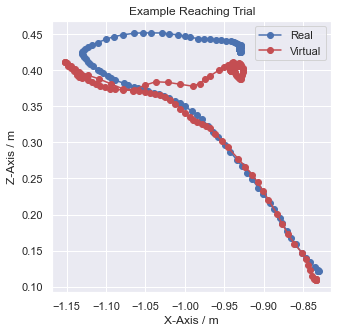

In [24]:
mask = (df_all['PtxID'] == 'Poppy') & (df_all['height'] == 'high') & (df_all['tempos'] == '120')& (df_all['targetID'] == 'row_C3')  & (df_all['gameObjectName'] == 'r_index_fingernail_marker')
real_mask = (df_all['PtxID'] == 'Poppy') & (df_all['height'] == 'high') & (df_all['tempos'] == '120')& (df_all['targetID'] == 'row_C3')  & (df_all['gameObjectName'] == 'realFingerTip')

plt.plot(df_all[real_mask]['xPos'].values[-1-150:-1], df_all[real_mask]['zPos'].values[-1-150:-1],'b-o')
plt.plot(df_all[mask]['xPos'].values[-1-150:-1], df_all[mask]['zPos'].values[-1-150:-1],'r-o')

plt.title('Example Reaching Trial')
plt.ylabel('Z-Axis / m')
plt.xlabel('X-Axis / m')
plt.legend(['Real','Virtual'])
# plt.xlim([-1.175, -0.8])
# plt.ylim([0, 0.55])

plt.savefig(ptx + "_" + str(np.round(time.time())) + '_ExampleReach.png', dpi=600, bbox_inches='tight')

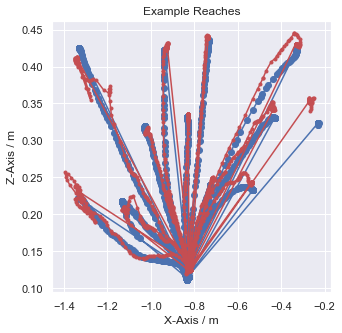

In [25]:
mask = (df_all['PtxID'] == 'Poppy') & (df_all['height'] == 'low') & (df_all['tempos'] == '80')  & (df_all['gameObjectName'] == 'r_index_fingernail_marker')
realmask = (df_all['PtxID'] == 'Poppy') & (df_all['height'] == 'low') & (df_all['tempos'] == '80')  & (df_all['gameObjectName'] == 'realFingerTip')

plt.plot(df_all[realmask]['xPos'].values[-1-1500:-1], df_all[realmask]['zPos'].values[-1-1500:-1],'b-o')
plt.plot(df_all[mask]['xPos'].values[-1-1500:-1], df_all[mask]['zPos'].values[-1-1500:-1],'r-o', ms = 3)

plt.title('Example Reaches')
plt.ylabel('Z-Axis / m')
plt.xlabel('X-Axis / m')

plt.savefig(str(np.round(time.time())) + '_ExampleReaches.png', dpi=600, bbox_inches='tight')

In [27]:
mask_1 = (df_all['PtxID'] == 'Poppy') & (df_all['height'] == 'mid') & (df_all['tempos'] == '120')& (df_all['targetID'] == 'row_A1')  & (df_all['gameObjectName'] == 'r_index_fingernail_marker')
trials = pd.unique(df_all[mask_1]['TrialNum'])

if len(trials) < 1:
    mask_1 = (df_all['PtxID'] == 'Poppy') & (df_all['height'] == 'noHeight') & (df_all['tempos'] == '120')& (df_all['targetID'] == 'row_A1')  & (df_all['gameObjectName'] == 'r_index_fingernail_marker')
    trials = pd.unique(df_all[mask_1]['TrialNum'])

trials

# mask_2 = (df_all['TrialNum'] == trials[5]) & (df_all['PtxID'] == 'Davide') & (df_all['height'] == 'noHeight') & (df_all['tempo'] == '120')& (df_all['targetID'] == 'row_A1')  & (df_all['gameObjectName'] == 'r_index_fingernail_marker')
# plt.plot(df_all[mask_2]['zPos'],'r-')

array(['71', '53', '35', '17'], dtype=object)

# Distortion Analysis
### For each height and tempo create a dataframe with all the movement end-points for each target for the distortion analysis 

In [28]:
targetID = pd.unique(df_all['targetID'])
participants = pd.unique(df_all['PtxID'])

height = 'low'
tempo = '120'
trow = 'B'

df_terminal_pos = None 

for p in participants:
    
    target = []

    for t in targetID: # Go through all the targets but ...

        if trow in t: # ... only select one specific row 
            
            
#           mask_virtualfinger = (df_all['height'] == height) & (df_all['tempo'] == tempo)  & (df_all['PtxID'] == p)  & (df_all['targetID'] == t)  & (df_all['gameObjectName'] == 'r_index_fingernail_marker')
#           mask_realfinger = (df_all['height'] == height) & (df_all['tempo'] == tempo) & (df_all['PtxID'] == p)  & (df_all['targetID'] == t)  & (df_all['gameObjectName'] == 'realFingerTip')

            Row_A_point_x = []
            Row_A_point_z = []
            ste_x = []
            ste_z = []

            vRow_A_point_x = []
            vRow_A_point_z = []
            vste_x = []
            vste_z = []
            
            target.append(t)


            mask_1 = (df_all['PtxID'] == p) & (df_all['height'] == height) & (df_all['tempos'] == tempo) & (df_all['targetID'] == t)  & (df_all['gameObjectName'] == 'r_index_fingernail_marker')
            trials = pd.unique(df_all[mask_1]['TrialNum'])
            
            if len(trials) < 1:
                mask_1 = (df_all['PtxID'] == p) & (df_all['height'] == 'noHeight') & (df_all['tempos'] == tempo) & (df_all['targetID'] == t)  & (df_all['gameObjectName'] == 'r_index_fingernail_marker')
                trials = pd.unique(df_all[mask_1]['TrialNum'])
            
            for tr in trials:
                
                mask_2_virt = (df_all['TrialNum'] == tr) & (df_all['PtxID'] == p) & (df_all['height'] == height) & (df_all['tempos'] == tempo)& (df_all['targetID'] == t)
                
                # Virtual finger tip terminal position
                end_points_x = df_all[mask_2_virt & (df_all['gameObjectName'] == 'r_index_fingernail_marker')]['xPos'].values[-1-30:-1]
                end_points_z = df_all[mask_2_virt & (df_all['gameObjectName'] == 'r_index_fingernail_marker')]['zPos'].values[-1-30:-1]
                vRow_A_point_x.append(np.round(np.nanmean(end_points_x, axis=0),5))
                vste_x.append(np.round(np.nanstd(end_points_x) / np.sqrt(len(end_points_x)), 5))
                vRow_A_point_z.append(np.round(np.nanmean(end_points_z, axis=0),5))
                vste_z.append(np.round(np.nanstd(end_points_z) / np.sqrt(len(end_points_z)), 5))

                # Real finger tip terminal position            
                end_points_x = df_all[mask_2_virt & (df_all['gameObjectName'] == 'realFingerTip')]['xPos'].values[-1-30:-1]
                end_points_z = df_all[mask_2_virt & (df_all['gameObjectName'] == 'realFingerTip')]['zPos'].values[-1-30:-1]
                Row_A_point_x.append(np.round(np.nanmean(end_points_x, axis=0),5))
                ste_x.append(np.round(np.nanstd(end_points_x) / np.sqrt(len(end_points_x)), 5))
                Row_A_point_z.append(np.round(np.nanmean(end_points_z, axis=0),5))
                ste_z.append(np.round(np.nanstd(end_points_z) / np.sqrt(len(end_points_z)), 5))
                
            # Average across the trials 
            vRow_A_point_x = np.nanmean(vRow_A_point_x, axis=0)
            vste_x = np.nanmean(vste_x, axis=0)
            vRow_A_point_z = np.nanmean(vRow_A_point_z, axis=0)
            vste_z = np.nanmean(vste_z, axis=0)
            Row_A_point_x = np.nanmean(Row_A_point_x, axis=0)
            ste_x = np.nanmean(ste_x, axis=0)
            Row_A_point_z = np.nanmean(Row_A_point_z, axis=0)
            ste_z = np.nanmean(ste_z, axis=0)

#             dataList = zip(Row_A_point_x, Row_A_point_z, ste_x, ste_z, vRow_A_point_x , vRow_A_point_z, vste_x, vste_z, t)
#             tmpDF = pd.DataFrame(dataList, columns=['Real_X_Pos','Real_Z_Pos', 'Real_SE_X',  'Real_SE_Z', 'Virtual_X_Pos','Virtual_Z_Pos', 'Virtual_SE_X',  'Virtual_SE_Z', 'targetID'])    

            dataList = [Row_A_point_x, Row_A_point_z, ste_x, ste_z, vRow_A_point_x , vRow_A_point_z, vste_x, vste_z, t, p, height, tempo]
            tmpDF = pd.DataFrame([dataList], columns = ['Real_X_Pos', 'Real_Z_Pos', 'Real_X_SE','Real_Z_SE', 'Virt_X_Pos','Virt_Z_Pos','Virt_X_SE','Virt_Z_SE','TargetID','PtxID','Height','Tempo'])
#             tmpDF = pd.DataFrame.from_dict(dataDict.items())
#             tmpDF = pd.DataFrame.from_dict(dataDict.items(), orient = 'index').T
#             tmpDF = pd.DataFrame(list(dataDict.items()), orient = 'index', columns = ['Real_X_Pos', 'Real_Z_Pos','Virt_X_Pos','Virt_Z_Pos','Real_X_SE','Real_Z_SE','Virt_X_SE','Virt_Z_SE','TargetID','PtxID','Height','Tempo'])

            # Save info to dataframe
            if df_terminal_pos is None:
                df_terminal_pos = tmpDF
            else:
                df_terminal_pos = pd.concat((df_terminal_pos, tmpDF))

<ipython-input-28-1de57ca52772>:63: RuntimeWarning: Mean of empty slice
  vRow_A_point_x = np.nanmean(vRow_A_point_x, axis=0)
<ipython-input-28-1de57ca52772>:64: RuntimeWarning: Mean of empty slice
  vste_x = np.nanmean(vste_x, axis=0)
<ipython-input-28-1de57ca52772>:65: RuntimeWarning: Mean of empty slice
  vRow_A_point_z = np.nanmean(vRow_A_point_z, axis=0)
<ipython-input-28-1de57ca52772>:66: RuntimeWarning: Mean of empty slice
  vste_z = np.nanmean(vste_z, axis=0)
<ipython-input-28-1de57ca52772>:67: RuntimeWarning: Mean of empty slice
  Row_A_point_x = np.nanmean(Row_A_point_x, axis=0)
<ipython-input-28-1de57ca52772>:68: RuntimeWarning: Mean of empty slice
  ste_x = np.nanmean(ste_x, axis=0)
<ipython-input-28-1de57ca52772>:69: RuntimeWarning: Mean of empty slice
  Row_A_point_z = np.nanmean(Row_A_point_z, axis=0)
<ipython-input-28-1de57ca52772>:70: RuntimeWarning: Mean of empty slice
  ste_z = np.nanmean(ste_z, axis=0)


Text(0.5, 0, 'Target ID')

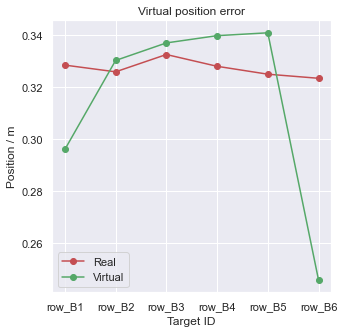

In [29]:
# Sort indeces according to target id:
df_terminal_pos = df_terminal_pos.sort_values(by=['TargetID', 'PtxID'])

mymask = (df_terminal_pos['PtxID'] == ptx) 
plt.plot(df_terminal_pos[mymask]['TargetID'], df_terminal_pos[mymask]['Real_Z_Pos'],'r-o')
plt.plot(df_terminal_pos[mymask]['TargetID'], df_terminal_pos[mymask]['Virt_Z_Pos'],'g-o')
plt.legend(['Real','Virtual'])
plt.title('Virtual position error')
plt.ylabel('Position / m')
plt.xlabel('Target ID')

In [30]:
def undistort_point(undistortion_params,r_distorted):
    undistorted = r_distorted*(1 + undistortion_params[0] * r_distorted
                               + undistortion_params[1] * r_distorted**2
                               + undistortion_params[2] * r_distorted**3)
    return(undistorted)

def fun(undistortion_params,r_distorted, un_distorted):
    #Compute residuals.
    undistorted = undistort_point(undistortion_params, r_distorted)
#     return((undistorted - np.linspace(np.nanmean(r_distorted,axis=0),np.nanmean(r_distorted,axis=0),len(r_distorted)))).ravel()
    return((undistorted - un_distorted)).ravel()

In [31]:
r_distorted = df_terminal_pos[mymask]['Virt_Z_Pos']
un_distorted = df_terminal_pos[mymask]['Real_Z_Pos']

x0 = np.zeros(3).ravel()
res = least_squares(fun, x0,  verbose=2, ftol=1e-12,loss='linear', args=([r_distorted, un_distorted]))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.7390e-03                                    3.33e-03    
       1              2         3.1132e-03      6.26e-04       1.00e+00       4.14e-04    
       2              3         2.1559e-03      9.57e-04       2.00e+00       3.48e-04    
       3              4         7.9128e-04      1.36e-03       4.00e+00       2.01e-04    
       4              5         1.0122e-04      6.90e-04       8.00e+00       2.28e-06    
       5              6         7.4651e-05      2.66e-05       1.60e+01       1.28e-06    
       6              7         3.6697e-05      3.80e-05       3.20e+01       7.45e-07    
       7              8         1.7424e-05      1.93e-05       4.42e+01       2.18e-09    
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 3.7390e-03, final cost 1.7424e-05, first-order optimality 2.18e-09.


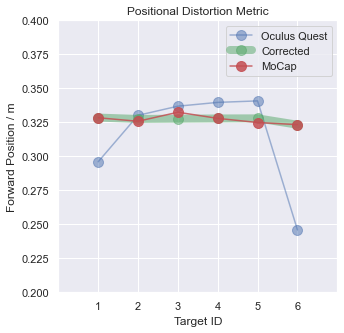

In [32]:
xvalz = [0,1,2,3,4,5]
undistorted = undistort_point(res.x,r_distorted)    
plt.plot(xvalz, r_distorted,label='Oculus Quest',alpha=0.5,color='b',marker = 'o', ms = 10)
plt.plot(xvalz, undistorted,label='Corrected',alpha=0.5,color='g',marker = 'o', ms = 10,linewidth = 8)
plt.plot(xvalz, un_distorted,label='MoCap',alpha=0.85,color='r',marker = 'o', ms = 10)
# plt.plot(xvalz, np.linspace(np.nanmean(r_distorted,axis=0),np.nanmean(r_distorted[0],axis=0),len(r_distorted)),label='target',alpha=0.85,color='r')
plt.title('Positional Distortion Metric')
plt.xlabel('Target ID')
plt.ylabel('Forward Position / m')
plt.xlim([-1, 6])
plt.ylim([0.2, 0.4])
plt.xticks([-1,0,1,2,3,4,5,6],['','1','2','3','4','5','6',''])

plt.legend()
plt.savefig(ptx + "_" + str(np.round(time.time())) + '_DistortionMetric.png', dpi=600, bbox_inches='tight')

In [33]:
print(np.round(res.x)) # 

[ 11. -60.  78.]


In [36]:
def ComputeErrors2(df_in):
    masktemp = (df_in['gameObjectName'] == 'realFingerTip')
    adaptationTrialNumbers = pd.unique(df_in[masktemp].TrialNum)
    # np.random.shuffle(adaptationTrialNumbers)

    df_out = None # If arrays are to be saved use this 
    dat_List = []

    ptxes = pd.unique(df_in['PtxID'])
    
    for ptx in ptxes:
        print('Ptx: ', ptx)
        
        for i in range(len(adaptationTrialNumbers)):
            realFingerMask = (df_in['PtxID'] == ptx) & (df_in['gameObjectName'] == 'realFingerTip') & (df_in['TrialNum'] == adaptationTrialNumbers[i])
            virtualFingerMask = (df_in['PtxID'] == ptx) & (df_in['gameObjectName'] == 'r_index_fingernail_marker') & (df_in['TrialNum'] == adaptationTrialNumbers[i])
            ptxMask = (df_in['PtxID'] == ptx) & (df_in['gameObjectName'] == 'r_index_fingernail_marker') & (df_in['TrialNum'] == adaptationTrialNumbers[i])

            # timeMask = df.loc[(df['gameObjectName'] == 'realFingerTip') & (df['trialNumber'] == adaptationTrialNumbers[i]), ['time']]
            timeMask = df_in['TrialNum'] == adaptationTrialNumbers[i]

            try:

                plt.figure(1) # All positions
                plt.plot(df_in[realFingerMask].xPos, df_in[realFingerMask].zPos,'r')
                plt.plot(df_in[virtualFingerMask].xPos, df_in[virtualFingerMask].zPos,'g')
                plt.title('X-Z Position / m')
                plt.gca().set_aspect('equal', adjustable='box')
                plt.gca().set_aspect('equal', adjustable='box')
                plt.legend(['Real','Virtual'])

                ax = plt.figure(2)
                tangXZ_Real = np.sqrt(np.power(df_in[realFingerMask].xPos,2) + np.power(df_in[realFingerMask].zPos,2))
                tangXZ_Virt = np.sqrt(np.power(df_in[virtualFingerMask].xPos,2) + np.power(df_in[virtualFingerMask].zPos,2))

                print('Trial: ', i)

                try:
                    tangXZ_Real_Vel = np.abs(np.diff(savgol_filter(tangXZ_Real, 75, 4)))
                    tangXZ_Virt_Vel = np.abs(np.diff(savgol_filter(tangXZ_Virt, 75, 4)))


                    print('Past issue: ', i)

                    plt.plot(tangXZ_Real_Vel,'r')
                    plt.plot(tangXZ_Virt_Vel,'g')
                    plt.title('Lateral Velocity (x-z axis) $\mathregular{ms^{-1}}$')

                    # Sampling Frequency and Time
                    times = df_in[timeMask].time.tolist()
                    val = np.where(times == numpy.amin(times))
                    startTimeIdx = val[0][0]
                    # print('min: ', startTimeIdx)

                    print('Past 2nd issue: ', i)

                    plt.figure(3) 
                    plt.plot(times)
                    plt.plot(startTimeIdx, times[startTimeIdx], 'rx')
                    # print('Movement duration: ', times[-1], 's')
                    startMovIdx = int(np.round((startTimeIdx/10))) # Convert between time series and movement array by dividing by 10? 
                    sampleFreq = np.round(len(tangXZ_Real_Vel[startMovIdx:])/times[-1])
                    # print('Sampling Freq: ', sampleFreq)

                    print('Past 3rd issue: ', i)

                    #--------------- Cross-Correlation ---------------------------------------------
                    corr = np.correlate(tangXZ_Real_Vel - np.mean(tangXZ_Real_Vel), 
                                      tangXZ_Virt_Vel - np.mean(tangXZ_Virt_Vel),
                                      mode='full')
                    sampleDifference = np.argmax(tangXZ_Virt_Vel[20:]) - np.argmax(tangXZ_Real_Vel[20:])

                    print('Past correlation issue: ', i)

                    if sampleDifference > 50:
                        lag = (sampleDifference  * (1/sampleFreq)) * 1000
                        print('Lag is too large: ' , lag)
                    else: 
                        lag = (sampleDifference  * (1/sampleFreq)) * 1000
                        # print('Lag: ', np.round(lag), 'ms')

                        #--------------- Positional-Error ---------------------------------------------
                        # MSE = np.sum(np.power(np.abs((tangXZ_Real.values[20:] - tangXZ_Virt.values[20:]),2))) / len(tangXZ_Real.values[20:])

                        print('Past if statement: ', i)

                        MSE = np.round(np.sum(np.power(np.abs(tangXZ_Real.values[20:] - tangXZ_Virt.values[20:]),2)) / len(tangXZ_Real.values[20:]),4) * 100 # Convert to cm
                        endPosError = (np.round(np.nanmean(np.abs(tangXZ_Virt.values[-1-30:-1] - tangXZ_Real.values[-1-30:-1])),3)/30) * 100 # Convert to cm
                        posError = np.round(np.nanmean(np.abs(tangXZ_Virt.values[20:] - tangXZ_Real.values[20:])),3) * 100 # Convert to cm
                        velError = np.round(np.nanmean(np.abs(tangXZ_Virt_Vel[20:] - tangXZ_Real_Vel[20:])),3) # Convert to cm

                        # print('Mean Square Error: ', MSE, 'cm')
                        # print('Target Hit Error: ', endPosError, 'cm')
                        # print('Average Positional Error: ', posError, 'cm')
                        # print('Velocity Error: ', velError, 'ms-1')

                        dat_List.append([lag, MSE, endPosError, posError, velError, times[-1]])



                except Exception as e:
                    print('MY_ERROR: Size of array: ', len(tangXZ_Real))
                    zeroArray = np.tile(np.zeros, (1, 100))
                    tangXZ_Real_Vel = zeroArray
                    tangXZ_Virt_Vel = zeroArray

            except Exception as ex:
                print('My_Error_2: ', ex)
    
        
        df_tmp = pd.DataFrame(dat_List, columns =['Lag' ,'MSE_Error', 'Hit_Error', 'AvPos_Error', 'Vel_Error', 'Time'])
        df_tmp.insert(0, 'PtxID', ptx, True)

        if df_out is None:
            df_out = df_tmp
        else:
            df_out =df_out.loc[:,~df_out.columns.duplicated()]
            df_out = pd.concat((df_out, df_tmp))            
        # times = np.arange(0,)

    df_out =df_out.loc[:,~df_out.columns.duplicated()]
    return df_out

Ptx:  Susan
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation issue:  6
Past if statement:  6
Trial:  7
Past issue:  7
Past 2nd issue:  7
Past 3rd issue:  7
Past correlation issue:  7
Past if statement:  7
Trial:  8
Past issue:  8
Past 2nd issue:  8
Past 3rd issue:  8
Past correlation issue:  8
Pa

Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Davide
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation

Trial:  68
Past issue:  68
Past 2nd issue:  68
Past 3rd issue:  68
Past correlation issue:  68
Past if statement:  68
Trial:  69
Past issue:  69
Past 2nd issue:  69
Past 3rd issue:  69
Past correlation issue:  69
Past if statement:  69
Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Past if statement:  70
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Lag is too large:  687.5
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Poppy
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue: 

Trial:  67
Past issue:  67
Past 2nd issue:  67
Past 3rd issue:  67
Past correlation issue:  67
Past if statement:  67
Trial:  68
Past issue:  68
Past 2nd issue:  68
Past 3rd issue:  68
Past correlation issue:  68
Past if statement:  68
Trial:  69
Past issue:  69
Past 2nd issue:  69
Past 3rd issue:  69
Past correlation issue:  69
Past if statement:  69
Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Past if statement:  70
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Katrina
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd i

Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd issue:  64
Past correlation issue:  64
Past if statement:  64
Trial:  65
Past issue:  65
Past 2nd issue:  65
Past 3rd issue:  65
Past correlation issue:  65
Past if statement:  65
Trial:  66
Past issue:  66
Past 2nd issue:  66
Past 3rd issue:  66
Past correlation issue:  66
Past if statement:  66
Trial:  67
Past issue:  67
Past 2nd issue:  67
Past 3rd issue:  67
Past correlation issue:  67
Past if statement:  67
Trial:  68
Past issue:  68
Past 2nd issue:  68
Past 3rd issue:  68
Past correlation issue:  68
Past if statement:  68
Trial:  69
Past issue:  69
Past 2nd issue:  69
Past 3rd issue:  69
Past correlation issue:  69
Past if statement:  69
Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Past if statement:  70
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd 

Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd issue:  63
Past correlation issue:  63
Past if statement:  63
Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd issue:  64
Past correlation issue:  64
Past if statement:  64
Trial:  65
Past issue:  65
Past 2nd issue:  65
Past 3rd issue:  65
Past correlation issue:  65
Past if statement:  65
Trial:  66
Past issue:  66
Past 2nd issue:  66
Past 3rd issue:  66
Past correlation issue:  66
Past if statement:  66
Trial:  67
Past issue:  67
Past 2nd issue:  67
Past 3rd issue:  67
Past correlation issue:  67
Past if statement:  67
Trial:  68
Past issue:  68
Past 2nd issue:  68
Past 3rd 

Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd issue:  63
Past correlation issue:  63
Past if statement:  63
Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd issue:  64
Past correlation issue:  64
Past if statement:  64
Trial:  65
Past issue:  65
Past 2nd issue:  65
Past 3rd issue:  65
Past correlation issue:  65
Past if statement:  65
Trial:  66
Past issue:  66
Past 2nd issue:  66
Past 3rd 

Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Lag is too large:  1441.8604651162789
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd issue:  63
Past correlation issue:  63
Past if statement:  63
Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd issue:  64
Past correlation issue:  64
Past if statement:  64
Trial:  65
Past issue:  65
Past 2nd issue

Trial:  55
Past issue:  55
Past 2nd issue:  55
Past 3rd issue:  55
Past correlation issue:  55
Past if statement:  55
Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd issue:  56
Past correlation issue:  56
Past if statement:  56
Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd 

Trial:  53
Past issue:  53
Past 2nd issue:  53
Past 3rd issue:  53
Past correlation issue:  53
Past if statement:  53
Trial:  54
Past issue:  54
Past 2nd issue:  54
Past 3rd issue:  54
Past correlation issue:  54
Past if statement:  54
Trial:  55
Past issue:  55
Past 2nd issue:  55
Past 3rd issue:  55
Past correlation issue:  55
Past if statement:  55
Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd issue:  56
Past correlation issue:  56
Past if statement:  56
Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd 

Trial:  50
Past issue:  50
Past 2nd issue:  50
Past 3rd issue:  50
Past correlation issue:  50
Past if statement:  50
Trial:  51
Past issue:  51
Past 2nd issue:  51
Past 3rd issue:  51
Past correlation issue:  51
Past if statement:  51
Trial:  52
Past issue:  52
Past 2nd issue:  52
Past 3rd issue:  52
Past correlation issue:  52
Past if statement:  52
Trial:  53
Past issue:  53
Past 2nd issue:  53
Past 3rd issue:  53
Past correlation issue:  53
Past if statement:  53
Trial:  54
Past issue:  54
Past 2nd issue:  54
Past 3rd issue:  54
Past correlation issue:  54
Past if statement:  54
Trial:  55
Past issue:  55
Past 2nd issue:  55
Past 3rd issue:  55
Past correlation issue:  55
Past if statement:  55
Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd issue:  56
Past correlation issue:  56
Past if statement:  56
Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd 

Trial:  47
Past issue:  47
Past 2nd issue:  47
Past 3rd issue:  47
Past correlation issue:  47
Past if statement:  47
Trial:  48
Past issue:  48
Past 2nd issue:  48
Past 3rd issue:  48
Past correlation issue:  48
Past if statement:  48
Trial:  49
Past issue:  49
Past 2nd issue:  49
Past 3rd issue:  49
Past correlation issue:  49
Past if statement:  49
Trial:  50
Past issue:  50
Past 2nd issue:  50
Past 3rd issue:  50
Past correlation issue:  50
Past if statement:  50
Trial:  51
Past issue:  51
Past 2nd issue:  51
Past 3rd issue:  51
Past correlation issue:  51
Past if statement:  51
Trial:  52
Past issue:  52
Past 2nd issue:  52
Past 3rd issue:  52
Past correlation issue:  52
Past if statement:  52
Trial:  53
Past issue:  53
Past 2nd issue:  53
Past 3rd issue:  53
Past correlation issue:  53
Past if statement:  53
Trial:  54
Past issue:  54
Past 2nd issue:  54
Past 3rd issue:  54
Past correlation issue:  54
Past if statement:  54
Trial:  55
Past issue:  55
Past 2nd issue:  55
Past 3rd 

Trial:  44
Past issue:  44
Past 2nd issue:  44
Past 3rd issue:  44
Past correlation issue:  44
Past if statement:  44
Trial:  45
Past issue:  45
Past 2nd issue:  45
Past 3rd issue:  45
Past correlation issue:  45
Lag is too large:  888.8888888888888
Trial:  46
Past issue:  46
Past 2nd issue:  46
Past 3rd issue:  46
Past correlation issue:  46
Past if statement:  46
Trial:  47
Past issue:  47
Past 2nd issue:  47
Past 3rd issue:  47
Past correlation issue:  47
Past if statement:  47
Trial:  48
Past issue:  48
Past 2nd issue:  48
Past 3rd issue:  48
Past correlation issue:  48
Past if statement:  48
Trial:  49
Past issue:  49
Past 2nd issue:  49
Past 3rd issue:  49
Past correlation issue:  49
Past if statement:  49
Trial:  50
Past issue:  50
Past 2nd issue:  50
Past 3rd issue:  50
Past correlation issue:  50
Past if statement:  50
Trial:  51
Past issue:  51
Past 2nd issue:  51
Past 3rd issue:  51
Past correlation issue:  51
Lag is too large:  1675.0
Trial:  52
Past issue:  52
Past 2nd iss

Trial:  41
Past issue:  41
Past 2nd issue:  41
Past 3rd issue:  41
Past correlation issue:  41
Lag is too large:  798.165137614679
Trial:  42
Past issue:  42
Past 2nd issue:  42
Past 3rd issue:  42
Past correlation issue:  42
Past if statement:  42
Trial:  43
Past issue:  43
Past 2nd issue:  43
Past 3rd issue:  43
Past correlation issue:  43
Past if statement:  43
Trial:  44
Past issue:  44
Past 2nd issue:  44
Past 3rd issue:  44
Past correlation issue:  44
Past if statement:  44
Trial:  45
Past issue:  45
Past 2nd issue:  45
Past 3rd issue:  45
Past correlation issue:  45
Lag is too large:  465.2406417112299
Trial:  46
Past issue:  46
Past 2nd issue:  46
Past 3rd issue:  46
Past correlation issue:  46
Past if statement:  46
Trial:  47
Past issue:  47
Past 2nd issue:  47
Past 3rd issue:  47
Past correlation issue:  47
Past if statement:  47
Trial:  48
Past issue:  48
Past 2nd issue:  48
Past 3rd issue:  48
Past correlation issue:  48
Past if statement:  48
Trial:  49
Past issue:  49
Pa

Trial:  39
Past issue:  39
Past 2nd issue:  39
Past 3rd issue:  39
Past correlation issue:  39
Past if statement:  39
Trial:  40
Past issue:  40
Past 2nd issue:  40
Past 3rd issue:  40
Past correlation issue:  40
Past if statement:  40
Trial:  41
Past issue:  41
Past 2nd issue:  41
Past 3rd issue:  41
Past correlation issue:  41
Past if statement:  41
Trial:  42
Past issue:  42
Past 2nd issue:  42
Past 3rd issue:  42
Past correlation issue:  42
Past if statement:  42
Trial:  43
Past issue:  43
Past 2nd issue:  43
Past 3rd issue:  43
Past correlation issue:  43
Past if statement:  43
Trial:  44
Past issue:  44
Past 2nd issue:  44
Past 3rd issue:  44
Past correlation issue:  44
Past if statement:  44
Trial:  45
Past issue:  45
Past 2nd issue:  45
Past 3rd issue:  45
Past correlation issue:  45
Past if statement:  45
Trial:  46
Past issue:  46
Past 2nd issue:  46
Past 3rd issue:  46
Past correlation issue:  46
Past if statement:  46
Trial:  47
Past issue:  47
Past 2nd issue:  47
Past 3rd 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  11
Past issue:  11
Past 2nd issue:  11
Past 3rd issue:  11
Past correlation issue:  11
Past if statement:  11
Trial:  12
Past issue:  12
Past 2nd issue:  12
Past 3rd issue:  12
Past correlation issue:  12
Past if statement:  12
Trial:  13
Past issue:  13
Past 2nd issue:  13
Past 3rd issue:  13
Past correlation issue:  13
Past if statement:  13
Trial:  14
Past issue:  14
Past 2nd issue:  14
Past 3rd issue:  14
Past correlation issue:  14
Lag is too large:  1047.6190476190475
Trial:  15
Past issue:  15
Past 2nd issue:  15
Past 3rd issue:  15
Past correlation issue:  15
Past if statement:  15
Trial:  16
Past issue:  16
Past 2nd issue:  16
Past 3rd issue:  16
Past correlation issue:  16
Lag is too large:  962.0253164556963
Trial:  17
Past issue:  17
Past 2nd issue:  17
Past 3rd issue:  17
Past correlation issue:  17
Past if statement:  17
Trial:  18
MY_ERROR: Size of array:  65
Trial:  19
Past issue:  19
Past 2nd issue:  19
Past 3rd issue:  19
Past correlation issue:  19
Past if st

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000
<ipython-input-36-13711597ef2f>:79: RuntimeWarning: invalid value encountered in multiply
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  27
Past issue:  27
Past 2nd issue:  27
Past 3rd issue:  27
Past correlation issue:  27
Past if statement:  27
Trial:  28
Past issue:  28
Past 2nd issue:  28
Past 3rd issue:  28
Past correlation issue:  28
Past if statement:  28
Trial:  29
Past issue:  29
Past 2nd issue:  29
Past 3rd issue:  29
Past correlation issue:  29
Past if statement:  29
Trial:  30
Past issue:  30
Past 2nd issue:  30
Past 3rd issue:  30
Past correlation issue:  30
Past if statement:  30
Trial:  31
Past issue:  31
Past 2nd issue:  31
Past 3rd issue:  31
Past correlation issue:  31
Past if statement:  31
Trial:  32
Past issue:  32
Past 2nd issue:  32
Past 3rd issue:  32
Past correlation issue:  32
Past if statement:  32
Trial:  33
Past issue:  33
Past 2nd issue:  33
Past 3rd issue:  33
Past correlation issue:  33
Past if statement:  33
Trial:  34
Past issue:  34
Past 2nd issue:  34
Past 3rd issue:  34
Past correlation issue:  34
Past if statement:  34
Trial:  35
Past issue:  35
Past 2nd issue:  35
Past 3rd 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Davide
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Lag is too large:  923.8095238095239
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation issue:  6
Past if statement:  6
Trial:  7
Past issue:  7
Past 2nd issue:  7
Past 3rd issue:  7
Past co

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  11
Past issue:  11
Past 2nd issue:  11
Past 3rd issue:  11
Past correlation issue:  11
Past if statement:  11
Trial:  12
Past issue:  12
Past 2nd issue:  12
Past 3rd issue:  12
Past correlation issue:  12
Past if statement:  12
Trial:  13
Past issue:  13
Past 2nd issue:  13
Past 3rd issue:  13
Past correlation issue:  13
Past if statement:  13
Trial:  14
Past issue:  14
Past 2nd issue:  14
Past 3rd issue:  14
Past correlation issue:  14
Past if statement:  14
Trial:  15
Past issue:  15
Past 2nd issue:  15
Past 3rd issue:  15
Past correlation issue:  15
Past if statement:  15
Trial:  16
Past issue:  16
Past 2nd issue:  16
Past 3rd issue:  16
Past correlation issue:  16
Past if statement:  16
Trial:  17
Past issue:  17
Past 2nd issue:  17
Past 3rd issue:  17
Past correlation issue:  17
Past if statement:  17
Trial:  18
Past issue:  18
Past 2nd issue:  18
Past 3rd issue:  18
Past correlation issue:  18
Past if statement:  18
Trial:  19
Past issue:  19
Past 2nd issue:  19
Past 3rd 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000
<ipython-input-36-13711597ef2f>:79: RuntimeWarning: invalid value encountered in multiply
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  27
Past issue:  27
Past 2nd issue:  27
Past 3rd issue:  27
Past correlation issue:  27
Past if statement:  27
Trial:  28
Past issue:  28
Past 2nd issue:  28
Past 3rd issue:  28
Past correlation issue:  28
Past if statement:  28
Trial:  29
Past issue:  29
Past 2nd issue:  29
Past 3rd issue:  29
Past correlation issue:  29
Past if statement:  29
Trial:  30
Past issue:  30
Past 2nd issue:  30
Past 3rd issue:  30
Past correlation issue:  30
Lag is too large:  602.0408163265306
Trial:  31
Past issue:  31
Past 2nd issue:  31
Past 3rd issue:  31
Past correlation issue:  31
Past if statement:  31
Trial:  32
Past issue:  32
Past 2nd issue:  32
Past 3rd issue:  32
Past correlation issue:  32
Past if statement:  32
Trial:  33
Past issue:  33
Past 2nd issue:  33
Past 3rd issue:  33
Past correlation issue:  33
Past if statement:  33
Trial:  34
Past issue:  34
Past 2nd issue:  34
Past 3rd issue:  34
Past correlation issue:  34
Past if statement:  34
Trial:  35
Past issue:  35
Past 2nd issue:

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Poppy
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation issue:  6
Past if statement:  6
Trial:  7
Past issue:  7
Past 2nd issue:  7
Past 3rd issue:  7
Past correlation issue:

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000
<ipython-input-36-13711597ef2f>:79: RuntimeWarning: invalid value encountered in multiply
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  11
Past issue:  11
Past 2nd issue:  11
Past 3rd issue:  11
Past correlation issue:  11
Past if statement:  11
Trial:  12
Past issue:  12
Past 2nd issue:  12
Past 3rd issue:  12
Past correlation issue:  12
Past if statement:  12
Trial:  13
Past issue:  13
Past 2nd issue:  13
Past 3rd issue:  13
Past correlation issue:  13
Past if statement:  13
Trial:  14
Past issue:  14
Past 2nd issue:  14
Past 3rd issue:  14
Past correlation issue:  14
Past if statement:  14
Trial:  15
Past issue:  15
Past 2nd issue:  15
Past 3rd issue:  15
Past correlation issue:  15
Past if statement:  15
Trial:  16
Past issue:  16
Past 2nd issue:  16
Past 3rd issue:  16
Past correlation issue:  16
Past if statement:  16
Trial:  17
Past issue:  17
Past 2nd issue:  17
Past 3rd issue:  17
Past correlation issue:  17
Lag is too large:  983.0508474576271
Trial:  18
Past issue:  18
Past 2nd issue:  18
Past 3rd issue:  18
Past correlation issue:  18
Past if statement:  18
Trial:  19
Past issue:  19
Past 2nd issue:

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  27
Past issue:  27
Past 2nd issue:  27
Past 3rd issue:  27
Past correlation issue:  27
Past if statement:  27
Trial:  28
Past issue:  28
Past 2nd issue:  28
Past 3rd issue:  28
Past correlation issue:  28
Past if statement:  28
Trial:  29
Past issue:  29
Past 2nd issue:  29
Past 3rd issue:  29
Past correlation issue:  29
Past if statement:  29
Trial:  30
Past issue:  30
Past 2nd issue:  30
Past 3rd issue:  30
Past correlation issue:  30
Past if statement:  30
Trial:  31
Past issue:  31
Past 2nd issue:  31
Past 3rd issue:  31
Past correlation issue:  31
Past if statement:  31
Trial:  32
Past issue:  32
Past 2nd issue:  32
Past 3rd issue:  32
Past correlation issue:  32
Past if statement:  32
Trial:  33
Past issue:  33
Past 2nd issue:  33
Past 3rd issue:  33
Past correlation issue:  33
Past if statement:  33
Trial:  34
Past issue:  34
Past 2nd issue:  34
Past 3rd issue:  34
Past correlation issue:  34
Past if statement:  34
Trial:  35
Past issue:  35
Past 2nd issue:  35
Past 3rd 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Katrina
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation issue:  6
Past if statement:  6
Trial:  7
Past issue:  7
Past 2nd issue:  7
Past 3rd issue:  7
Past correlation issu

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  11
Past issue:  11
Past 2nd issue:  11
Past 3rd issue:  11
Past correlation issue:  11
Past if statement:  11
Trial:  12
Past issue:  12
Past 2nd issue:  12
Past 3rd issue:  12
Past correlation issue:  12
Past if statement:  12
Trial:  13
Past issue:  13
Past 2nd issue:  13
Past 3rd issue:  13
Past correlation issue:  13
Past if statement:  13
Trial:  14
Past issue:  14
Past 2nd issue:  14
Past 3rd issue:  14
Past correlation issue:  14
Past if statement:  14
Trial:  15
Past issue:  15
Past 2nd issue:  15
Past 3rd issue:  15
Past correlation issue:  15
Past if statement:  15
Trial:  16
Past issue:  16
Past 2nd issue:  16
Past 3rd issue:  16
Past correlation issue:  16
Past if statement:  16
Trial:  17
Past issue:  17
Past 2nd issue:  17
Past 3rd issue:  17
Past correlation issue:  17
Past if statement:  17
Trial:  18
Past issue:  18
Past 2nd issue:  18
Past 3rd issue:  18
Past correlation issue:  18
Past if statement:  18
Trial:  19
Past issue:  19
Past 2nd issue:  19
Past 3rd 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000
<ipython-input-36-13711597ef2f>:79: RuntimeWarning: invalid value encountered in multiply
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  27
Past issue:  27
Past 2nd issue:  27
Past 3rd issue:  27
Past correlation issue:  27
Past if statement:  27
Trial:  28
Past issue:  28
Past 2nd issue:  28
Past 3rd issue:  28
Past correlation issue:  28
Past if statement:  28
Trial:  29
Past issue:  29
Past 2nd issue:  29
Past 3rd issue:  29
Past correlation issue:  29
Past if statement:  29
Trial:  30
Past issue:  30
Past 2nd issue:  30
Past 3rd issue:  30
Past correlation issue:  30
Past if statement:  30
Trial:  31
Past issue:  31
Past 2nd issue:  31
Past 3rd issue:  31
Past correlation issue:  31
Past if statement:  31
Trial:  32
Past issue:  32
Past 2nd issue:  32
Past 3rd issue:  32
Past correlation issue:  32
Past if statement:  32
Trial:  33
Past issue:  33
Past 2nd issue:  33
Past 3rd issue:  33
Past correlation issue:  33
Past if statement:  33
Trial:  34
Past issue:  34
Past 2nd issue:  34
Past 3rd issue:  34
Past correlation issue:  34
Past if statement:  34
Trial:  35
Past issue:  35
Past 2nd issue:  35
Past 3rd 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Pete
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation issue:  6
Past if statement:  6
Trial:  7
Past issue:  7
Past 2nd issue:  7
Past 3rd issue:  7
Past correlation issue: 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  11
Past issue:  11
Past 2nd issue:  11
Past 3rd issue:  11
Past correlation issue:  11
Past if statement:  11
Trial:  12
Past issue:  12
Past 2nd issue:  12
Past 3rd issue:  12
Past correlation issue:  12
Past if statement:  12
Trial:  13
Past issue:  13
Past 2nd issue:  13
Past 3rd issue:  13
Past correlation issue:  13
Past if statement:  13
Trial:  14
Past issue:  14
Past 2nd issue:  14
Past 3rd issue:  14
Past correlation issue:  14
Past if statement:  14
Trial:  15
Past issue:  15
Past 2nd issue:  15
Past 3rd issue:  15
Past correlation issue:  15
Past if statement:  15
Trial:  16
Past issue:  16
Past 2nd issue:  16
Past 3rd issue:  16
Past correlation issue:  16
Past if statement:  16
Trial:  17
Past issue:  17
Past 2nd issue:  17
Past 3rd issue:  17
Past correlation issue:  17
Past if statement:  17
Trial:  18
Past issue:  18
Past 2nd issue:  18
Past 3rd issue:  18
Past correlation issue:  18
Past if statement:  18
Trial:  19
Past issue:  19
Past 2nd issue:  19
Past 3rd 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  27
Past issue:  27
Past 2nd issue:  27
Past 3rd issue:  27
Past correlation issue:  27
Past if statement:  27
Trial:  28
Past issue:  28
Past 2nd issue:  28
Past 3rd issue:  28
Past correlation issue:  28
Past if statement:  28
Trial:  29
Past issue:  29
Past 2nd issue:  29
Past 3rd issue:  29
Past correlation issue:  29
Lag is too large:  951.923076923077
Trial:  30
Past issue:  30
Past 2nd issue:  30
Past 3rd issue:  30
Past correlation issue:  30
Past if statement:  30
Trial:  31
Past issue:  31
Past 2nd issue:  31
Past 3rd issue:  31
Past correlation issue:  31
Past if statement:  31
Trial:  32
Past issue:  32
Past 2nd issue:  32
Past 3rd issue:  32
Past correlation issue:  32
Past if statement:  32
Trial:  33
Past issue:  33
Past 2nd issue:  33
Past 3rd issue:  33
Past correlation issue:  33
Past if statement:  33
Trial:  34
Past issue:  34
Past 2nd issue:  34
Past 3rd issue:  34
Past correlation issue:  34
Past if statement:  34
Trial:  35
Past issue:  35
Past 2nd issue: 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Susan
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation issue:  6
Past if statement:  6
Trial:  7
Past issue:  7
Past 2nd issue:  7
Past 3rd issue:  7
Past correlation issue:

Trial:  69
Past issue:  69
Past 2nd issue:  69
Past 3rd issue:  69
Past correlation issue:  69
Past if statement:  69
Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Lag is too large:  1090.909090909091
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Lag is too large:  1101.871101871102
Ptx:  Poppy
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:

Trial:  66
Past issue:  66
Past 2nd issue:  66
Past 3rd issue:  66
Past correlation issue:  66
Past if statement:  66
Trial:  67
Past issue:  67
Past 2nd issue:  67
Past 3rd issue:  67
Past correlation issue:  67
Past if statement:  67
Trial:  68
Past issue:  68
Past 2nd issue:  68
Past 3rd issue:  68
Past correlation issue:  68
Past if statement:  68
Trial:  69
Past issue:  69
Past 2nd issue:  69
Past 3rd issue:  69
Past correlation issue:  69
Past if statement:  69
Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Lag is too large:  1675.6756756756758
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Katrina


<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation issue:  6
Past if statement:  6
Trial:  7
Past issue:  7
Past 2nd issue:  7
Past 3rd issue:  7
Past correlation issue:  7
Past if statement:  7
Trial:  8
Past issue:  8
Past 2nd issue:  8
Past 3rd issue:  8
Past correlation issue:  8
Past if statem

Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Past if statement:  70
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Pete


<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation issue:  6
Past if statement:  6
Trial:  7
Past issue:  7
Past 2nd issue:  7
Past 3rd issue:  7
Past correlation issue:  7
Past if statement:  7
Trial:  8
Past issue:  8
Past 2nd issue:  8
Past 3rd issue:  8
Past correlation issue:  8
Past if statem

Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Past if statement:  70
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Susan


<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Past if statement:  4
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue:  5
Past correlation issue:  5
Past if statement:  5
Trial:  6
Past issue:  6
Past 2nd issue:  6
Past 3rd issue:  6
Past correlation issue:  6
Past if statement:  6
Trial:  7
Past issue:  7
Past 2nd issue:  7
Past 3rd issue:  7
Past correlation issue:  7
Past if statement:  7
Trial:  8
Past issue:  8
Past 2nd issue:  8
Past 3rd issue:  8
Past correlation issue:  8
Past if statem

Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Past if statement:  70
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Davide
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd issue:  2
Past correlation issue:  2
Past if statement:  2
Trial:  3
Past issue:  3
Past 2nd issue:  3
Past 3rd issue:  3
Past correlation issue:  3
Past if statement:  3
Trial:  4
Past issue:  4
Past 2nd issue:  4
Past 3rd issue:  4
Past correlation issue:  4
Lag is too large:  178.6833855799373
Trial:  5
Past issue:  5
Past 2nd issue:  5
Past 3rd issue

Trial:  67
Past issue:  67
Past 2nd issue:  67
Past 3rd issue:  67
Past correlation issue:  67
Past if statement:  67
Trial:  68
Past issue:  68
Past 2nd issue:  68
Past 3rd issue:  68
Past correlation issue:  68
Past if statement:  68
Trial:  69
Past issue:  69
Past 2nd issue:  69
Past 3rd issue:  69
Past correlation issue:  69
Past if statement:  69
Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Past if statement:  70
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd issue:  72
Past correlation issue:  72
Past if statement:  72
Ptx:  Poppy
Trial:  0
Past issue:  0
Past 2nd issue:  0
Past 3rd issue:  0
Past correlation issue:  0
Past if statement:  0
Trial:  1
Past issue:  1
Past 2nd issue:  1
Past 3rd issue:  1
Past correlation issue:  1
Past if statement:  1
Trial:  2
Past issue:  2
Past 2nd issue:  2
Past 3rd iss

Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd issue:  64
Past correlation issue:  64
Past if statement:  64
Trial:  65
Past issue:  65
Past 2nd issue:  65
Past 3rd issue:  65
Past correlation issue:  65
Past if statement:  65
Trial:  66
Past issue:  66
Past 2nd issue:  66
Past 3rd issue:  66
Past correlation issue:  66
Past if statement:  66
Trial:  67
Past issue:  67
Past 2nd issue:  67
Past 3rd issue:  67
Past correlation issue:  67
Past if statement:  67
Trial:  68
Past issue:  68
Past 2nd issue:  68
Past 3rd issue:  68
Past correlation issue:  68
Past if statement:  68
Trial:  69
Past issue:  69
Past 2nd issue:  69
Past 3rd issue:  69
Past correlation issue:  69
Past if statement:  69
Trial:  70
Past issue:  70
Past 2nd issue:  70
Past 3rd issue:  70
Past correlation issue:  70
Past if statement:  70
Trial:  71
Past issue:  71
Past 2nd issue:  71
Past 3rd issue:  71
Past correlation issue:  71
Past if statement:  71
Trial:  72
Past issue:  72
Past 2nd issue:  72
Past 3rd 

Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd issue:  63
Past correlation issue:  63
Past if statement:  63
Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd issue:  64
Past correlation issue:  64
Past if statement:  64
Trial:  65
Past issue:  65
Past 2nd issue:  65
Past 3rd issue:  65
Past correlation issue:  65
Past if statement:  65
Trial:  66
Past issue:  66
Past 2nd issue:  66
Past 3rd issue:  66
Past correlation issue:  66
Past if statement:  66
Trial:  67
Past issue:  67
Past 2nd issue:  67
Past 3rd issue:  67
Past correlation issue:  67
Past if statement:  67
Trial:  68
Past issue:  68
Past 2nd issue:  68
Past 3rd issue:  68
Past correlation issue:  68
Past if statement:  68
Trial:  69
Past issue:  69
Past 2nd issue:  69
Past 3rd 

Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd issue:  63
Past correlation issue:  63
Past if statement:  63
Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd issue:  64
Past correlation issue:  64
Past if statement:  64
Trial:  65
Past issue:  65
Past 2nd issue:  65
Past 3rd issue:  65
Past correlation issue:  65
Past if statement:  65
Trial:  66
Past issue:  66
Past 2nd issue:  66
Past 3rd 

Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd issue:  56
Past correlation issue:  56
Past if statement:  56
Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd issue:  63
Past correlation issue:  63
Past if statement:  63
Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd 

Trial:  54
Past issue:  54
Past 2nd issue:  54
Past 3rd issue:  54
Past correlation issue:  54
Past if statement:  54
Trial:  55
Past issue:  55
Past 2nd issue:  55
Past 3rd issue:  55
Past correlation issue:  55
Past if statement:  55
Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd issue:  56
Past correlation issue:  56
Past if statement:  56
Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd 

Trial:  51
Past issue:  51
Past 2nd issue:  51
Past 3rd issue:  51
Past correlation issue:  51
Past if statement:  51
Trial:  52
Past issue:  52
Past 2nd issue:  52
Past 3rd issue:  52
Past correlation issue:  52
Past if statement:  52
Trial:  53
Past issue:  53
Past 2nd issue:  53
Past 3rd issue:  53
Past correlation issue:  53
Past if statement:  53
Trial:  54
Past issue:  54
Past 2nd issue:  54
Past 3rd issue:  54
Past correlation issue:  54
Past if statement:  54
Trial:  55
Past issue:  55
Past 2nd issue:  55
Past 3rd issue:  55
Past correlation issue:  55
Past if statement:  55
Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd issue:  56
Past correlation issue:  56
Past if statement:  56
Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd 

Trial:  48
Past issue:  48
Past 2nd issue:  48
Past 3rd issue:  48
Past correlation issue:  48
Past if statement:  48
Trial:  49
Past issue:  49
Past 2nd issue:  49
Past 3rd issue:  49
Past correlation issue:  49
Past if statement:  49
Trial:  50
Past issue:  50
Past 2nd issue:  50
Past 3rd issue:  50
Past correlation issue:  50
Past if statement:  50
Trial:  51
Past issue:  51
Past 2nd issue:  51
Past 3rd issue:  51
Past correlation issue:  51
Past if statement:  51
Trial:  52
Past issue:  52
Past 2nd issue:  52
Past 3rd issue:  52
Past correlation issue:  52
Past if statement:  52
Trial:  53
Past issue:  53
Past 2nd issue:  53
Past 3rd issue:  53
Past correlation issue:  53
Past if statement:  53
Trial:  54
Past issue:  54
Past 2nd issue:  54
Past 3rd issue:  54
Past correlation issue:  54
Past if statement:  54
Trial:  55
Past issue:  55
Past 2nd issue:  55
Past 3rd issue:  55
Past correlation issue:  55
Past if statement:  55
Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd 

Trial:  45
Past issue:  45
Past 2nd issue:  45
Past 3rd issue:  45
Past correlation issue:  45
Past if statement:  45
Trial:  46
Past issue:  46
Past 2nd issue:  46
Past 3rd issue:  46
Past correlation issue:  46
Past if statement:  46
Trial:  47
Past issue:  47
Past 2nd issue:  47
Past 3rd issue:  47
Past correlation issue:  47
Past if statement:  47
Trial:  48
Past issue:  48
Past 2nd issue:  48
Past 3rd issue:  48
Past correlation issue:  48
Past if statement:  48
Trial:  49
Past issue:  49
Past 2nd issue:  49
Past 3rd issue:  49
Past correlation issue:  49
Past if statement:  49
Trial:  50
Past issue:  50
Past 2nd issue:  50
Past 3rd issue:  50
Past correlation issue:  50
Past if statement:  50
Trial:  51
Past issue:  51
Past 2nd issue:  51
Past 3rd issue:  51
Past correlation issue:  51
Past if statement:  51
Trial:  52
Past issue:  52
Past 2nd issue:  52
Past 3rd issue:  52
Past correlation issue:  52
Past if statement:  52
Trial:  53
Past issue:  53
Past 2nd issue:  53
Past 3rd 

Trial:  42
Past issue:  42
Past 2nd issue:  42
Past 3rd issue:  42
Past correlation issue:  42
Past if statement:  42
Trial:  43
Past issue:  43
Past 2nd issue:  43
Past 3rd issue:  43
Past correlation issue:  43
Past if statement:  43
Trial:  44
Past issue:  44
Past 2nd issue:  44
Past 3rd issue:  44
Past correlation issue:  44
Past if statement:  44
Trial:  45
Past issue:  45
Past 2nd issue:  45
Past 3rd issue:  45
Past correlation issue:  45
Past if statement:  45
Trial:  46
Past issue:  46
Past 2nd issue:  46
Past 3rd issue:  46
Past correlation issue:  46
Past if statement:  46
Trial:  47
Past issue:  47
Past 2nd issue:  47
Past 3rd issue:  47
Past correlation issue:  47
Past if statement:  47
Trial:  48
Past issue:  48
Past 2nd issue:  48
Past 3rd issue:  48
Past correlation issue:  48
Past if statement:  48
Trial:  49
Past issue:  49
Past 2nd issue:  49
Past 3rd issue:  49
Past correlation issue:  49
Past if statement:  49
Trial:  50
Past issue:  50
Past 2nd issue:  50
Past 3rd 

Trial:  39
Past issue:  39
Past 2nd issue:  39
Past 3rd issue:  39
Past correlation issue:  39
Past if statement:  39
Trial:  40
Past issue:  40
Past 2nd issue:  40
Past 3rd issue:  40
Past correlation issue:  40
Past if statement:  40
Trial:  41
Past issue:  41
Past 2nd issue:  41
Past 3rd issue:  41
Past correlation issue:  41
Past if statement:  41
Trial:  42
Past issue:  42
Past 2nd issue:  42
Past 3rd issue:  42
Past correlation issue:  42
Past if statement:  42
Trial:  43
Past issue:  43
Past 2nd issue:  43
Past 3rd issue:  43
Past correlation issue:  43
Past if statement:  43
Trial:  44
Past issue:  44
Past 2nd issue:  44
Past 3rd issue:  44
Past correlation issue:  44
Past if statement:  44
Trial:  45
Past issue:  45
Past 2nd issue:  45
Past 3rd issue:  45
Past correlation issue:  45
Past if statement:  45
Trial:  46
Past issue:  46
Past 2nd issue:  46
Past 3rd issue:  46
Past correlation issue:  46
Past if statement:  46
Trial:  47
Past issue:  47
Past 2nd issue:  47
Past 3rd 

Trial:  36
Past issue:  36
Past 2nd issue:  36
Past 3rd issue:  36
Past correlation issue:  36
Past if statement:  36
Trial:  37
Past issue:  37
Past 2nd issue:  37
Past 3rd issue:  37
Past correlation issue:  37
Past if statement:  37
Trial:  38
Past issue:  38
Past 2nd issue:  38
Past 3rd issue:  38
Past correlation issue:  38
Past if statement:  38
Trial:  39
Past issue:  39
Past 2nd issue:  39
Past 3rd issue:  39
Past correlation issue:  39
Past if statement:  39
Trial:  40
Past issue:  40
Past 2nd issue:  40
Past 3rd issue:  40
Past correlation issue:  40
Past if statement:  40
Trial:  41
Past issue:  41
Past 2nd issue:  41
Past 3rd issue:  41
Past correlation issue:  41
Past if statement:  41
Trial:  42
Past issue:  42
Past 2nd issue:  42
Past 3rd issue:  42
Past correlation issue:  42
Past if statement:  42
Trial:  43
Past issue:  43
Past 2nd issue:  43
Past 3rd issue:  43
Past correlation issue:  43
Past if statement:  43
Trial:  44
Past issue:  44
Past 2nd issue:  44
Past 3rd 

Trial:  35
Past issue:  35
Past 2nd issue:  35
Past 3rd issue:  35
Past correlation issue:  35
Past if statement:  35
Trial:  36
Past issue:  36
Past 2nd issue:  36
Past 3rd issue:  36
Past correlation issue:  36
Past if statement:  36
Trial:  37
Past issue:  37
Past 2nd issue:  37
Past 3rd issue:  37
Past correlation issue:  37
Past if statement:  37
Trial:  38
Past issue:  38
Past 2nd issue:  38
Past 3rd issue:  38
Past correlation issue:  38
Past if statement:  38
Trial:  39
Past issue:  39
Past 2nd issue:  39
Past 3rd issue:  39
Past correlation issue:  39
Lag is too large:  765.7657657657658
Trial:  40
Past issue:  40
Past 2nd issue:  40
Past 3rd issue:  40
Past correlation issue:  40
Past if statement:  40
Trial:  41
Past issue:  41
Past 2nd issue:  41
Past 3rd issue:  41
Past correlation issue:  41
Past if statement:  41
Trial:  42
Past issue:  42
Past 2nd issue:  42
Past 3rd issue:  42
Past correlation issue:  42
Past if statement:  42
Trial:  43
Past issue:  43
Past 2nd issue:

Trial:  32
Past issue:  32
Past 2nd issue:  32
Past 3rd issue:  32
Past correlation issue:  32
Past if statement:  32
Trial:  33
Past issue:  33
Past 2nd issue:  33
Past 3rd issue:  33
Past correlation issue:  33
Past if statement:  33
Trial:  34
Past issue:  34
Past 2nd issue:  34
Past 3rd issue:  34
Past correlation issue:  34
Past if statement:  34
Trial:  35
Past issue:  35
Past 2nd issue:  35
Past 3rd issue:  35
Past correlation issue:  35
Past if statement:  35
Trial:  36
Past issue:  36
Past 2nd issue:  36
Past 3rd issue:  36
Past correlation issue:  36
Past if statement:  36
Trial:  37
Past issue:  37
Past 2nd issue:  37
Past 3rd issue:  37
Past correlation issue:  37
Past if statement:  37
Trial:  38
Past issue:  38
Past 2nd issue:  38
Past 3rd issue:  38
Past correlation issue:  38
Past if statement:  38
Trial:  39
Past issue:  39
Past 2nd issue:  39
Past 3rd issue:  39
Past correlation issue:  39
Past if statement:  39
Trial:  40
Past issue:  40
Past 2nd issue:  40
Past 3rd 

Trial:  29
Past issue:  29
Past 2nd issue:  29
Past 3rd issue:  29
Past correlation issue:  29
Past if statement:  29
Trial:  30
Past issue:  30
Past 2nd issue:  30
Past 3rd issue:  30
Past correlation issue:  30
Past if statement:  30
Trial:  31
Past issue:  31
Past 2nd issue:  31
Past 3rd issue:  31
Past correlation issue:  31
Past if statement:  31
Trial:  32
Past issue:  32
Past 2nd issue:  32
Past 3rd issue:  32
Past correlation issue:  32
Past if statement:  32
Trial:  33
Past issue:  33
Past 2nd issue:  33
Past 3rd issue:  33
Past correlation issue:  33
Past if statement:  33
Trial:  34
Past issue:  34
Past 2nd issue:  34
Past 3rd issue:  34
Past correlation issue:  34
Past if statement:  34
Trial:  35
Past issue:  35
Past 2nd issue:  35
Past 3rd issue:  35
Past correlation issue:  35
Past if statement:  35
Trial:  36
Past issue:  36
Past 2nd issue:  36
Past 3rd issue:  36
Past correlation issue:  36
Past if statement:  36
Trial:  37
Past issue:  37
Past 2nd issue:  37
Past 3rd 

<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd issue:  56
Past correlation issue:  56
Past if statement:  56
Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Lag is too large:  3750.0
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd issue:  63
Past correlation issue:  63
Past if statement:  63
Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3

Trial:  53
Past issue:  53
Past 2nd issue:  53
Past 3rd issue:  53
Past correlation issue:  53
Past if statement:  53
Trial:  54
Past issue:  54
Past 2nd issue:  54
Past 3rd issue:  54
Past correlation issue:  54
Past if statement:  54
Trial:  55
Past issue:  55
Past 2nd issue:  55
Past 3rd issue:  55
Past correlation issue:  55
Past if statement:  55
Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd issue:  56
Past correlation issue:  56
Past if statement:  56
Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58


<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60


<ipython-input-36-13711597ef2f>:79: RuntimeWarning: divide by zero encountered in double_scalars
  lag = (sampleDifference  * (1/sampleFreq)) * 1000


Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd issue:  63
Past correlation issue:  63
Past if statement:  63
Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd issue:  64
Past correlation issue:  64
Past if statement:  64
Trial:  65
Past issue:  65
Past 2nd issue:  65
Past 3rd issue:  65
Past correlation issue:  65
Past if statement:  65
Trial:  66
Past issue:  66
Past 2nd issue:  66
Past 3rd issue:  66
Past correlation issue:  66
Past if statement:  66
Trial:  67
Past issue:  67
Past 2nd issue:  67
Past 3rd issue:  67
Past correlation issue:  67
Past if statement:  67
Trial:  68
Past issue:  68
Past 2nd issue:  68
Past 3rd issue:  68
Past correlation issue:  68
Past if statement:  68
Trial:  69
Past issue:  69
Past 2nd issue:  69
Past 3rd 

Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd issue:  63
Past correlation issue:  63
Past if statement:  63
Trial:  64
Past issue:  64
Past 2nd issue:  64
Past 3rd issue:  64
Past correlation issue:  64
Past if statement:  64
Trial:  65
Past issue:  65
Past 2nd issue:  65
Past 3rd issue:  65
Past correlation issue:  65
Past if statement:  65
Trial:  66
Past issue:  66
Past 2nd issue:  66
Past 3rd 

Trial:  55
Past issue:  55
Past 2nd issue:  55
Past 3rd issue:  55
Past correlation issue:  55
Past if statement:  55
Trial:  56
Past issue:  56
Past 2nd issue:  56
Past 3rd issue:  56
Past correlation issue:  56
Past if statement:  56
Trial:  57
Past issue:  57
Past 2nd issue:  57
Past 3rd issue:  57
Past correlation issue:  57
Past if statement:  57
Trial:  58
Past issue:  58
Past 2nd issue:  58
Past 3rd issue:  58
Past correlation issue:  58
Past if statement:  58
Trial:  59
Past issue:  59
Past 2nd issue:  59
Past 3rd issue:  59
Past correlation issue:  59
Past if statement:  59
Trial:  60
Past issue:  60
Past 2nd issue:  60
Past 3rd issue:  60
Past correlation issue:  60
Past if statement:  60
Trial:  61
Past issue:  61
Past 2nd issue:  61
Past 3rd issue:  61
Past correlation issue:  61
Past if statement:  61
Trial:  62
Past issue:  62
Past 2nd issue:  62
Past 3rd issue:  62
Past correlation issue:  62
Past if statement:  62
Trial:  63
Past issue:  63
Past 2nd issue:  63
Past 3rd 

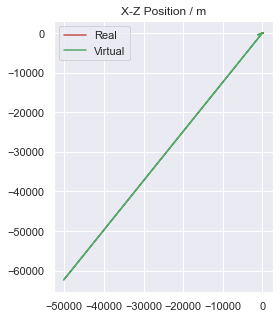

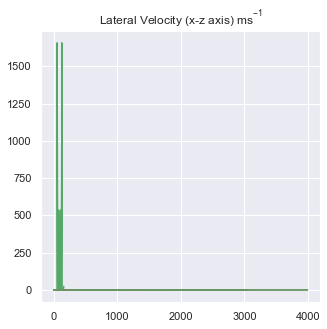

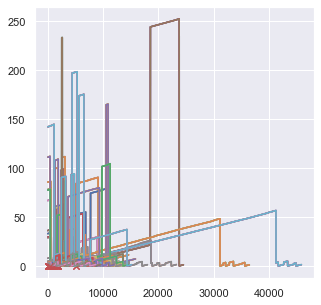

In [37]:
df_bmp160_low_errors = ComputeErrors2(df_bmp160_low)
df_bmp160_mid_errors = ComputeErrors2(df_bmp160_mid)
df_bmp160_high_errors = ComputeErrors2(df_bmp160_high)

df_bmp120_low_errors = ComputeErrors2(df_bmp120_low)
df_bmp120_mid_errors = ComputeErrors2(df_bmp120_mid)
df_bmp120_high_errors = ComputeErrors2(df_bmp120_high)

df_bmp80_low_errors = ComputeErrors2(df_bmp80_low)
df_bmp80_mid_errors = ComputeErrors2(df_bmp80_mid)
df_bmp80_high_errors = ComputeErrors2(df_bmp80_high)

In [38]:
print('Processed ptx: ', pd.unique(df_bmp160_low['PtxID']))
print('Original ptx: ', pd.unique(df_all['PtxID']))


Processed ptx:  ['Susan' 'Davide' 'Poppy' 'Katrina' 'Pete']
Original ptx:  ['Susan' 'Davide' 'Joe' 'Poppy' 'Katrina' 'Max' 'Pete']


In [39]:
df_bmp160_mid_errors
# df_bmp80_low_errors

,PtxID,Lag,MSE_Error,Hit_Error,AvPos_Error,Vel_Error,Time
0,Susan,13.513514,0.17,0.173333,3.8,0.000,1.171722
1,Susan,83.333333,1.89,0.543333,12.0,0.002,1.115616
2,Susan,13.333333,0.01,0.016667,0.7,0.000,1.114990
3,Susan,24.096386,0.01,0.016667,0.7,0.000,1.002411
4,Susan,24.390244,0.03,0.023333,1.5,0.001,1.085785
...,...,...,...,...,...,...,...
279,Pete,6.578947,0.15,0.193333,3.0,0.001,1.144089
280,Pete,11.173184,0.02,0.020000,1.1,0.001,1.130600
281,Pete,8.196721,0.01,0.036667,1.0,0.000,1.104706
282,Pete,16.260163,0.03,0.053333,1.4,0.001,1.114334


In [40]:
def AverageSTE(dataz):
    ste = np.nanstd(dataz) / np.sqrt(len(dataz))
    avr = np.nanmean(dataz)

    return avr,ste


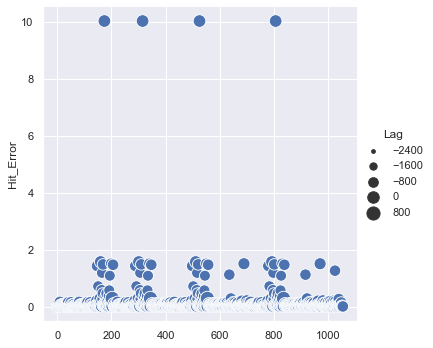

In [41]:

# sns.displot(df_bmp160_mid_errors, x="Lag", binwidth=10)
xVals = np.arange(len(df_bmp160_high_errors.Lag))
# g = sns.relplot(x=xVals, y="Lag", hue="Hit_Error", data=df_bmp160_mid_errors)
g = sns.relplot(x=xVals, y="Hit_Error", size="Lag", sizes=(10, 200), data=df_bmp160_high_errors)

In [42]:
bmp120_mid_errorsArr

NameError: name 'bmp120_mid_errorsArr' is not defined

In [ ]:
# MSE, endPosError, posError, velError
bmp80_low_errorsArr = np.array(df_bmp80_low_errors)
bmp120_mid_errorsArr = np.array(df_bmp120_mid_errors)
bmp160_high_errorsArr = np.array(df_bmp160_high_errors)

plt.figure()
# plt.plot(bmp80_low_errorsArr[:,0],'r-o')
plt.plot(bmp120_mid_errorsArr[:,1],'g-o')
plt.plot(bmp160_high_errorsArr[:,2],'b-o')
plt.legend(['End PosErr','Path Error'])
plt.ylim([-0.5, 100])
plt.title('Error Between Quest and MoCap')
plt.xlabel('Trial Number')
plt.ylabel('Error / cm')

# plt.figure()
# av,se = AverageSTE(bmp120_mid_errorsArr[:,0])
# plt.errorbar([0,1,2], [av, np.nan, np.nan], [np.nan, np.nan, se],ms=15,color='r')

# plt.legend(['MSE','End PosErr','Average Error'])

plt.savefig(str(np.round(time.time())) + '_Errors_EndPointPath.png', dpi=600, bbox_inches='tight')

In [ ]:
# # Set theme
# sns.set_style('whitegrid')
 
# # Violin plot
# sns.violinplot(x='xPos', y='zPos', data=df)

In [ ]:
df_bmp160_mid_errors

In [ ]:

trials = np.arange(0, len(df_bmp80_low_errors))
df_bmp80_low_errors.insert(0, 'TrialNum', trials)

trials = np.arange(0, len(df_bmp120_low_errors))
df_bmp120_low_errors.insert(0, 'TrialNum', trials)

trials = np.arange(0, len(df_bmp160_low_errors))
df_bmp160_low_errors.insert(0, 'TrialNum', trials)

trials = np.arange(0, len(df_bmp80_mid_errors))
df_bmp80_mid_errors.insert(0, 'TrialNum', trials)
trials = np.arange(0, len(df_bmp120_mid_errors))
df_bmp120_mid_errors.insert(0, 'TrialNum', trials)
trials = np.arange(0, len(df_bmp160_mid_errors))
df_bmp160_mid_errors.insert(0, 'TrialNum', trials)

trials = np.arange(0, len(df_bmp80_high_errors))
df_bmp80_high_errors.insert(0, 'TrialNum', trials)
trials = np.arange(0, len(df_bmp120_high_errors))
df_bmp120_high_errors.insert(0, 'TrialNum', trials)
trials = np.arange(0, len(df_bmp160_high_errors))
df_bmp160_high_errors.insert(0, 'TrialNum', trials)

df_bmp160_high_errors

In [ ]:
df_bmp160_high_errors

In [ ]:
# Density Plot
# sns.kdeplot(df.xPos, df.zPos)
fig, axs = plt.subplots(3, 3, figsize=(12, 5), sharey=True)
fig.suptitle('AvPos_Error / cm')

axs[0, 0].set_title('Low 80 BPM')
sns.distplot(df_bmp80_low_errors.AvPos_Error, ax=axs[0,0])

axs[0, 1].set_title('LOW 120 BPM')
sns.distplot(df_bmp120_low_errors.AvPos_Error, ax=axs[0,1])

axs[0, 2].set_title('LOW 160 BPM')
sns.distplot(df_bmp160_low_errors.AvPos_Error, ax=axs[0,2])

axs[1, 0].set_title('MID 80 BPM')
sns.distplot(df_bmp80_mid_errors.AvPos_Error, ax=axs[1,0])

axs[1, 1].set_title('MID 120 BPM')
sns.distplot(df_bmp120_mid_errors.AvPos_Error, ax=axs[1,1])

axs[1, 2].set_title('MID 160 BPM')
sns.distplot(df_bmp160_mid_errors.AvPos_Error, ax=axs[1,2])

axs[2, 0].set_title('HIGH 80 BPM')
sns.distplot(df_bmp80_high_errors.AvPos_Error, ax=axs[2,0])

axs[2, 1].set_title('HIGH 120 BPM')
sns.distplot(df_bmp120_high_errors.AvPos_Error, ax=axs[2,1])

axs[2, 2].set_title('HIGH 160 BPM')
sns.distplot(df_bmp160_high_errors.AvPos_Error, ax=axs[2,2])

plt.figure()
plt.title('HIGH 160 BPM')
sns.distplot(df_bmp160_high_errors.AvPos_Error)


## Create master metric table

In [ ]:
df_bmp80_low_errors

In [ ]:
df_all_errors = None

df_bmp80_low_errors.insert(0, 'height', 0, True)
df_bmp80_low_errors.insert(0, 'tempo', 80, True)
df_all_errors = df_bmp80_low_errors 

df_bmp120_low_errors.insert(0, 'height', 0, True)
df_bmp120_low_errors.insert(0, 'tempo', 120, True)
df_all_errors =  df = pd.concat((df_all_errors, df_bmp120_low_errors))

df_bmp160_low_errors.insert(0, 'height', 0, True)
df_bmp160_low_errors.insert(0, 'tempo', 160, True)
df_all_errors =  df = pd.concat((df_all_errors, df_bmp160_low_errors))

df_bmp80_mid_errors.insert(0, 'height', 1, True)
df_bmp80_mid_errors.insert(0, 'tempo', 80, True)
df_all_errors =  df = pd.concat((df_all_errors, df_bmp80_mid_errors))

df_bmp120_mid_errors.insert(0, 'height', 1, True)
df_bmp120_mid_errors.insert(0, 'tempo', 120, True)
df_all_errors =  df = pd.concat((df_all_errors, df_bmp120_mid_errors))

df_bmp160_mid_errors.insert(0, 'height', 2, True)
df_bmp160_mid_errors.insert(0, 'tempo', 160, True)
df_all_errors =  df = pd.concat((df_all_errors, df_bmp160_mid_errors))

df_bmp80_high_errors.insert(0, 'height', 2, True)
df_bmp80_high_errors.insert(0, 'tempo', 80, True)
df_all_errors =  df = pd.concat((df_all_errors, df_bmp80_high_errors))

df_bmp120_high_errors.insert(0, 'height', 2, True)
df_bmp120_high_errors.insert(0, 'tempo', 120, True)
df_all_errors =  df = pd.concat((df_all_errors, df_bmp120_high_errors))

df_bmp160_high_errors.insert(0, 'height', 2, True)
df_bmp160_high_errors.insert(0, 'tempo', 160, True)
df_all_errors =  df = pd.concat((df_all_errors, df_bmp160_high_errors))

df_all_errors

# TODO
- [ ] Incorporate targets into the analysis
- [ ] Cleanup the notebook 

In [ ]:
# sns.regplot(x='TrialNum', y='Lag', x_bins=4, data=df_bmp120_high_errors, x_estimator=np.mean)
# sns.violinplot(x='TrialNum', y='Lag', data=df_bmp120_high_errors)
# sns.regplot(x="TrialNum", y="Vel_Error", data=df_bmp120_high_errors,x_estimator=np.mean, logx=True)

# sns.relplot(x="TrialNum", y="MSE_Error", kind="line", data=df_bmp120_high_errors)

# sns.set_theme(style="whitegrid")
# sns.violinplot(data=df_bmp120_high_errors, x="Vel_Error", y="MSE_Error", hue="Lag", split=False, inner="quart", linewidth=1) #,palette={"Yes": "b", "No": ".85"})
# sns.despine(left=True)

sns.set_theme(style="darkgrid")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df_all_errors,
    x="TrialNum", y="Hit_Error", hue="height", size = "tempo", sizes=(75, 225), palette="Blues",alpha=0.85
)
plt.ylim([-0.25, 5])
plt.xlabel('Trial Number')
plt.ylabel('Positional Error / cm')
plt.title('Path Error Between Quest and MoCap')

plt.savefig(str(np.round(time.time())) + 'Path Error.png', dpi=600, bbox_inches='tight')

In [ ]:
df_all_errors.head(2)

In [ ]:
plt.figure()

# g1 = sns.barplot(x='tempo', y="height", palette="Reds", data=df_all_errors, estimator=np.nanmean)
# # plt.ylim([0, 0.15])
# plt.xlabel('Tempo')

ptxMeanErrTH = df_all_errors.groupby(['PtxID', 'tempo', 'height'])['Hit_Error'].mean()
df_Tempo_Height = ptxMeanErrTH.to_frame()


sns.scatterplot(x = 'tempo', y='height', size='Hit_Error', sizes=(100, 400), alpha=.5, data=df_Tempo_Height)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('Average Hit Error / m',fontsize=14)
plt.xlabel('Tempo (bpm)')
plt.xticks([80,120,160],['Slow','Medium','Fast'])
plt.ylabel('Height')
plt.yticks([0,1,2],['Low','Mid','Heigh'])

In [ ]:
plt.figure()
plt.subplot(221)
g1 = sns.barplot(x='tempo', y="Hit_Error", palette="Reds", data=df_all_errors, estimator=np.nanmean)
plt.ylim([0, 0.15])
plt.xlabel('Tempo')

plt.subplot(222)
g2 = sns.barplot(x='tempo', y="AvPos_Error", palette="Reds", data=df_all_errors, estimator=np.nanmean)
plt.ylim([0, 10])
plt.xlabel('Tempo')

plt.subplot(223)
g1 = sns.barplot(x='height', y="Hit_Error", palette="Blues", data=df_all_errors, estimator=np.nanmean)
plt.ylim([0, 0.15])
plt.xlabel('Height')

plt.subplot(224)
g2 = sns.barplot(x='height', y="AvPos_Error", palette="Blues", data=df_all_errors, estimator=np.nanmean)
plt.ylim([0, 10])
plt.xlabel('Height')

# plt.title('Average \n' + 'metric' + "\n \n")
# plt.ylabel('metric' + " / Degrees") #
# plt.xlabel('Phases')

In [ ]:
ax = sns.barplot(x="height", y="AvPos_Error", palette="Greens", data=df_all_errors, estimator=np.nanmean)
plt.title('Cummulative Path Error \n Between Quest and MoCap \n \n')
plt.ylabel('Positional Error / cm')
plt.xlabel('Height')
plt.xticks([0,1,2],['Low','Mid','High'])

plt.savefig(str(np.round(time.time())) + 'Cummulative Error Height.png', dpi=600, bbox_inches='tight')

statannot.add_stat_annotation(
    ax,
    data=df_all_errors,
    x='tempo',
    y='AvPos_Error',
    hue='height',
#     box_pairs=[("80", '80'), ('80','80'), ('80', '80')],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)

In [ ]:
lowMask = (df_all_errors['height'] == 0) & (df_all_errors['tempo'] == 120)
midMask = (df_all_errors['height'] == 1) & (df_all_errors['tempo'] == 120)
highMask = (df_all_errors['height'] == 2) & (df_all_errors['tempo'] == 120)

sci.ttest_ind(df_all_errors[midMask]['AvPos_Error'] , df_all_errors[highMask]['AvPos_Error'])

In [ ]:
# import scipy.stats as sci 

# PlotErrorBars2(bmaxZVels, 'r')
# PlotErrorBars2(amaxZVels, 'g')

# print('baseline: ', np.shape(bmaxZVels), 'adaptation: ', np.shape(amaxZVels))
# h = sci.ttest_ind(bmaxZVels, amaxZVels)
# print('ttest: ', h)

# plt.xticks(ticks = [0], labels=['Z'])
# plt.ylabel('Max Velocity ms-1')
# plt.xlabel('Axis')
# plt.title('Average Max Velocity')
# plt.legend(['Baseline','Adaptation'])

In [46]:
# # Reshape and average standard errors:
# print('Arr: ', vRow_A_point_z)

# # Sort indeces according to target id:
# targetSortedIdx = np.argsort(target)
# targets = np.take(target,targetSortedIdx)

# vrow_A_point_z = np.take(vRow_A_point_z, targetSortedIdx)

# print('\n target: ', target, ' targets: ', targets)

# xVals = np.linspace(0,len(targets)-1, len(targets))
# print('Size of X vals: ', np.shape(xVals), ' Vals: ', np.shape(vrow_A_point_z), ' SE: ', np.shape(ste_z))

# # Real finger tip 
# plt.figure()
# plt.subplot(121)
# plt.errorbar(xVals, vrow_A_point_z, vste_z, color = 'b', ms=8, alpha=0.5)
# plt.plot(vrow_A_point_z,'ko',ms=8,alpha=1.0)
# plt.xticks(xVals, targets, rotation=45)
# plt.ylim([0, 0.6])
# plt.xlim([-1, 6])
# plt.xlabel('Target ID')
# plt.ylabel('Virtual Finger Forward Position / m')
# plt.title(p + ' Virtual')

# # Real finger tip 
# row_A_point_z = np.take(Row_A_point_z,targetSortedIdx)
# targets = np.take(target,targetSortedIdx)

# plt.subplot(122)
# plt.errorbar(xVals, row_A_point_z, ste_z, color = 'b', ms=8, alpha=0.5)
# plt.plot(row_A_point_z,'ko',ms=8,alpha=1.0)
# plt.xticks(xVals, targets, rotation=45)
# plt.ylim([0, 0.6])
# plt.xlim([-1, 6])
# plt.xlabel('Target ID Row: ' + trow)
# plt.ylabel('Real Finger Forward Position / m')
# plt.title(p + ' Real')


In [35]:
#     try:
#         if len(vste_x) > 24:
#             vste_x = np.delete(vste_x, -1)
#         if len(vste_z) > 24:
#             vste_z = np.delete(vste_z, -1)
#         if len(ste_x) > 24:
#             ste_x = np.delete(ste_x, -1)
#         if len(ste_z) > 24:
#             ste_z = np.delete(ste_z, -1)
#     except Exception as e:
#         vste_x = np.zeros(6)
#         vste_z = np.zeros(6)
#         ste_x = np.zeros(6)
#         ste_z = np.zeros(6)
# 
#     vste_x = np.nanmean(np.reshape(vste_x, (4, 6)), axis=0)
#     vste_z = np.nanmean(np.reshape(vste_z, (4, 6)), axis=0)
#     ste_x = np.nanmean(np.reshape(ste_x, (4, 6)), axis=0)
#     ste_z = np.nanmean(np.reshape(ste_z, (4, 6)), axis=0)